# This is Keras/TensorFlow right? I thought this was Deep Learning?

- Output = activation(dot(input, kernel) + bias

That looks familiar doesn't it? It looks almost identical to y = mx+b. The dot product is sum of the products in two sequences. Well, if there is only two sequences with a length of 1 then it is just the product of those two numbers. This simplifies down to the all to familiar y = mx + b.


In [1]:
from formulas import *
import math
from sklearn import preprocessing, svm #scale, regresions, cross shuffle stats sepeareate data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import load_iris 
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

## Setup

In [2]:
# Example of dot product of two sequences of length 1
np.dot(2,1) + 5

7

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
df = yf.Ticker('TSLA').history(period="max").reset_index()
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
3357,2023-10-30 00:00:00-04:00,209.279999,210.880005,194.669998,197.360001,136448200,0.0,0.0
3358,2023-10-31 00:00:00-04:00,196.119995,202.800003,194.070007,200.839996,118068300,0.0,0.0
3359,2023-11-01 00:00:00-04:00,204.039993,205.990005,197.850006,205.660004,121661700,0.0,0.0
3360,2023-11-02 00:00:00-04:00,212.970001,219.199997,211.449997,218.509995,125987600,0.0,0.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

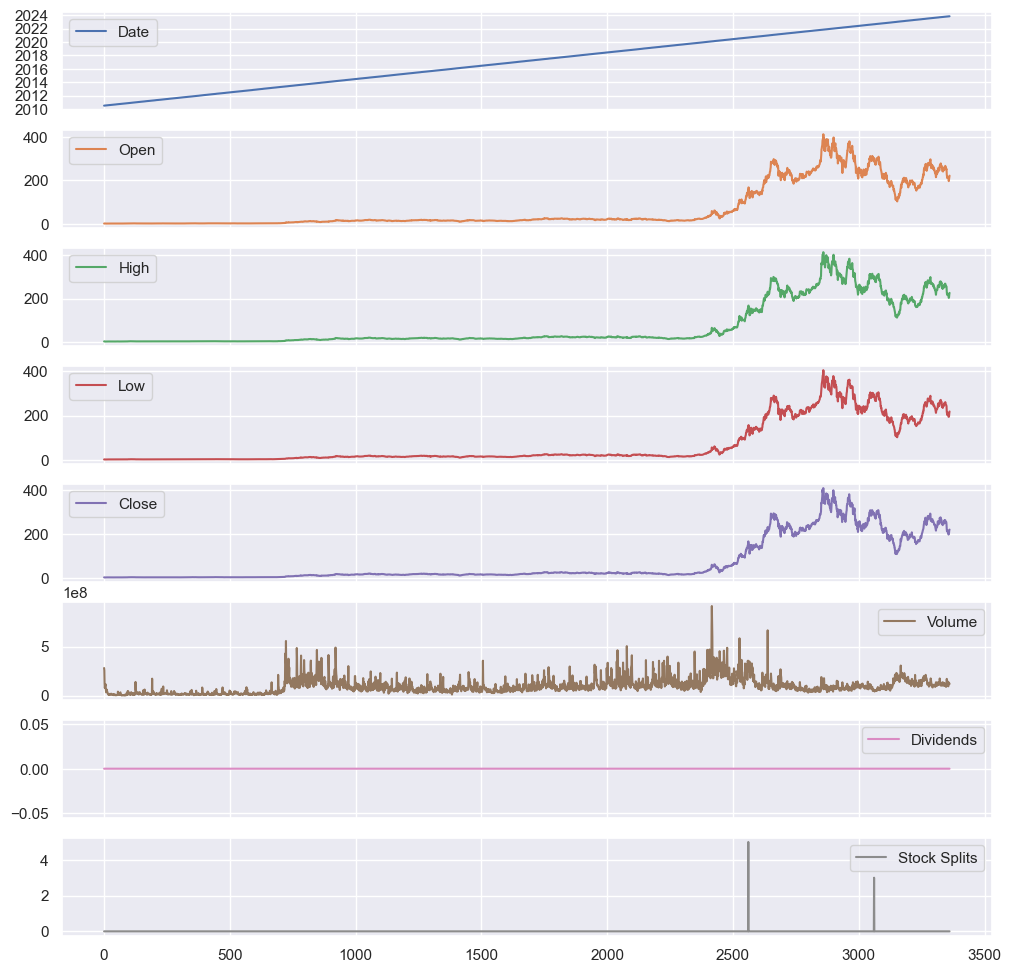

In [6]:
 df.plot(kind="line",figsize=(12,12),subplots=True)

In [7]:
df.shape

(3362, 8)

In [12]:
series = df['Close']

# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(df.Date == train_split_date)[0][0]
x_train = df.loc[df['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2021-12-01'
test_split_index = np.where(df.Date == test_split_date)[0][0]
x_test = df.loc[df['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = df.loc[(df['Date'] < test_split_date) & (df['Date'] > train_split_date)]['Close']

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 20-step windows for training. Every 20 steps is 1 trading month since the markets are only open Monday - Friday.

2393 2394 2876 2877 3361


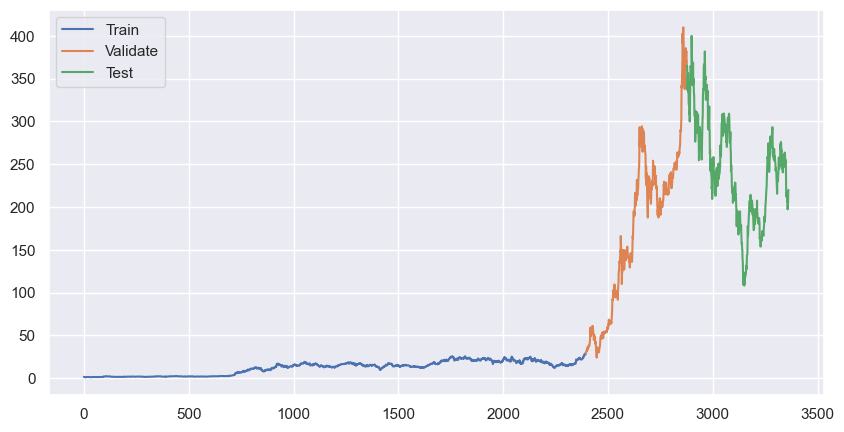

In [13]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [14]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

### Linear Model

In [15]:
# Clears any background saved info useful in notebooks
keras.backend.clear_session()

# Make reproducible 
tf.random.set_seed(42)
np.random.seed(42)

# set window size 
window_size = 20

# define training data (20 day windows shifted by 1 every time)
train_set = window_dataset(normalized_x_train.flatten(), window_size)

# Build Linear Model of a single dense layer
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Find optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.Nadam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
19/19 [==============================] - 6s 221ms/step - loss: 0.1958 - mae: 0.5152 - lr: 1.0000e-06
Epoch 2/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1957 - mae: 0.5150 - lr: 1.0798e-06
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1955 - mae: 0.5148 - lr: 1.1659e-06
Epoch 4/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1954 - mae: 0.5146 - lr: 1.2589e-06
Epoch 5/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1952 - mae: 0.5144 - lr: 1.3594e-06
Epoch 6/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1951 - mae: 0.5142 - lr: 1.4678e-06
Epoch 7/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1949 - mae: 0.5139 - lr: 1.5849e-06
Epoch 8/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1947 - mae: 0.5136 - lr: 1.7113e-06
Epoch 9/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1945 - mae: 0.5134 - lr: 1.8

(1e-06, 1.0, 0.0, 0.01)

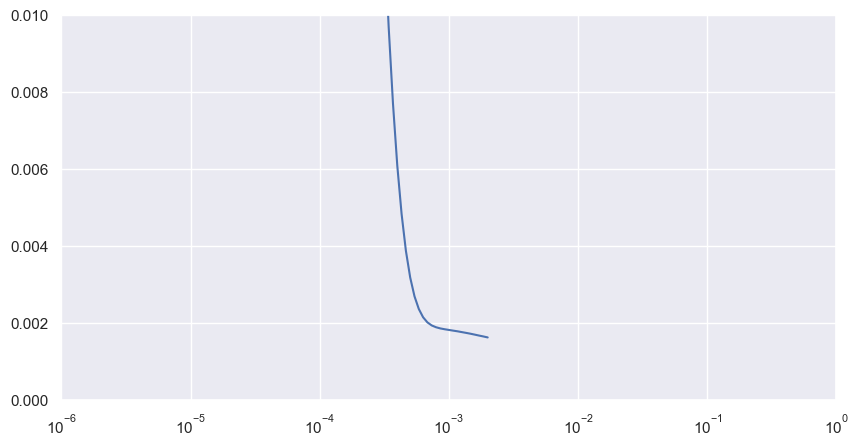

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .01])

In [24]:
# Useful to clear everything when rerunning cells
keras.backend.clear_session()

# Make this reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Create train and validate windows
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# 1 layer producing linear output for 1 output from each window of 20 days
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size]) # o
])

# Huber works well with "mae"
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])



Epoch 1/500
     11/Unknown - 1s 39ms/step - loss: 0.2706 - mae: 0.5864INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 65ms/step - loss: 0.3126 - mae: 0.6622 - val_loss: 8.6287 - val_mae: 9.1287
Epoch 2/500
11/19 [================>.............] - ETA: 0s - loss: 0.1646 - mae: 0.4466INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 0.1904 - mae: 0.5073 - val_loss: 6.5504 - val_mae: 7.0504
Epoch 3/500
11/19 [================>.............] - ETA: 0s - loss: 0.0885 - mae: 0.3220INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 0.1002 - mae: 0.3650 - val_loss: 4.7323 - val_mae: 5.2319
Epoch 4/500
11/19 [================>.............] - ETA: 0s - loss: 0.0418 - mae: 0.2253INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 0.0476 - mae: 0.2548 - val_loss: 3.2928 - val_mae: 3.7876
Epoch 5/500
11/19 [================>.............] - ETA: 0s - loss: 0.0185 - mae: 0.1565INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 0.0209 - mae: 0.1726 - val_loss: 2.2344 - val_mae: 2.7145
Epoch 6/500
11/19 [================>.............] - ETA: 0s - loss: 0.0077 - mae: 0.1061INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 0.0088 - mae: 0.1139 - val_loss: 1.5112 - val_mae: 1.9734
Epoch 7/500
11/19 [================>.............] - ETA: 0s - loss: 0.0036 - mae: 0.0733INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 0.0040 - mae: 0.0762 - val_loss: 1.0586 - val_mae: 1.4986
Epoch 8/500
11/19 [================>.............] - ETA: 0s - loss: 0.0021 - mae: 0.0563INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 0.0024 - mae: 0.0578 - val_loss: 0.8055 - val_mae: 1.2267
Epoch 9/500
11/19 [================>.............] - ETA: 0s - loss: 0.0018 - mae: 0.0514INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 0.0019 - mae: 0.0515 - val_loss: 0.6689 - val_mae: 1.0736
Epoch 10/500
11/19 [================>.............] - ETA: 0s - loss: 0.0017 - mae: 0.0507INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 43ms/step - loss: 0.0018 - mae: 0.0498 - val_loss: 0.6010 - val_mae: 0.9948
Epoch 11/500
11/19 [================>.............] - ETA: 0s - loss: 0.0017 - mae: 0.0499INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 61ms/step - loss: 0.0017 - mae: 0.0492 - val_loss: 0.5673 - val_mae: 0.9542
Epoch 12/500
11/19 [================>.............] - ETA: 0s - loss: 0.0017 - mae: 0.0502INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 64ms/step - loss: 0.0017 - mae: 0.0488 - val_loss: 0.5478 - val_mae: 0.9302
Epoch 13/500
 8/19 [===========>..................] - ETA: 0s - loss: 0.0016 - mae: 0.0502INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 0.0017 - mae: 0.0484 - val_loss: 0.5335 - val_mae: 0.9125
Epoch 14/500
11/19 [================>.............] - ETA: 0s - loss: 0.0016 - mae: 0.0486INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 0.0016 - mae: 0.0479 - val_loss: 0.5218 - val_mae: 0.8979
Epoch 15/500
11/19 [================>.............] - ETA: 0s - loss: 0.0016 - mae: 0.0481INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 0.0016 - mae: 0.0474 - val_loss: 0.5104 - val_mae: 0.8835
Epoch 16/500
 9/19 [=============>................] - ETA: 0s - loss: 0.0015 - mae: 0.0479INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 0.0016 - mae: 0.0469 - val_loss: 0.5008 - val_mae: 0.8712
Epoch 17/500
 9/19 [=============>................] - ETA: 0s - loss: 0.0014 - mae: 0.0467INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 0.0015 - mae: 0.0464 - val_loss: 0.4913 - val_mae: 0.8592
Epoch 18/500
 9/19 [=============>................] - ETA: 0s - loss: 0.0014 - mae: 0.0456INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 35ms/step - loss: 0.0015 - mae: 0.0458 - val_loss: 0.4810 - val_mae: 0.8461
Epoch 19/500
11/19 [================>.............] - ETA: 0s - loss: 0.0014 - mae: 0.0451INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 0.0015 - mae: 0.0453 - val_loss: 0.4715 - val_mae: 0.8339
Epoch 20/500
10/19 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0442INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 0.0014 - mae: 0.0448 - val_loss: 0.4600 - val_mae: 0.8193
Epoch 21/500
11/19 [================>.............] - ETA: 0s - loss: 0.0013 - mae: 0.0441INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 0.0014 - mae: 0.0442 - val_loss: 0.4488 - val_mae: 0.8053
Epoch 22/500
11/19 [================>.............] - ETA: 0s - loss: 0.0013 - mae: 0.0436INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 0.0014 - mae: 0.0437 - val_loss: 0.4405 - val_mae: 0.7946
Epoch 23/500
11/19 [================>.............] - ETA: 0s - loss: 0.0013 - mae: 0.0431INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 0.0013 - mae: 0.0432 - val_loss: 0.4299 - val_mae: 0.7811
Epoch 24/500
11/19 [================>.............] - ETA: 0s - loss: 0.0011 - mae: 0.0415INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 0.0013 - mae: 0.0427 - val_loss: 0.4228 - val_mae: 0.7720
Epoch 25/500
11/19 [================>.............] - ETA: 0s - loss: 0.0011 - mae: 0.0410INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 0.0013 - mae: 0.0421 - val_loss: 0.4125 - val_mae: 0.7587
Epoch 26/500
 9/19 [=============>................] - ETA: 0s - loss: 0.0011 - mae: 0.0403INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 37ms/step - loss: 0.0013 - mae: 0.0416 - val_loss: 0.4019 - val_mae: 0.7449
Epoch 27/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0410INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 41ms/step - loss: 0.0012 - mae: 0.0411 - val_loss: 0.3938 - val_mae: 0.7344
Epoch 28/500
11/19 [================>.............] - ETA: 0s - loss: 0.0010 - mae: 0.0390    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 37ms/step - loss: 0.0012 - mae: 0.0406 - val_loss: 0.3878 - val_mae: 0.7265
Epoch 29/500
11/19 [================>.............] - ETA: 0s - loss: 0.0010 - mae: 0.0383    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 0.0012 - mae: 0.0401 - val_loss: 0.3815 - val_mae: 0.7183
Epoch 30/500
11/19 [================>.............] - ETA: 0s - loss: 0.0010 - mae: 0.0387    INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 0.0012 - mae: 0.0396 - val_loss: 0.3715 - val_mae: 0.7052
Epoch 31/500
11/19 [================>.............] - ETA: 0s - loss: 9.4154e-04 - mae: 0.0374INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 0.0011 - mae: 0.0392 - val_loss: 0.3641 - val_mae: 0.6956
Epoch 32/500
11/19 [================>.............] - ETA: 0s - loss: 9.6858e-04 - mae: 0.0371INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 44ms/step - loss: 0.0011 - mae: 0.0387 - val_loss: 0.3574 - val_mae: 0.6868
Epoch 33/500
 9/19 [=============>................] - ETA: 0s - loss: 8.5151e-04 - mae: 0.0355INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 36ms/step - loss: 0.0011 - mae: 0.0382 - val_loss: 0.3520 - val_mae: 0.6795
Epoch 34/500
11/19 [================>.............] - ETA: 0s - loss: 9.3524e-04 - mae: 0.0363INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 0.0011 - mae: 0.0378 - val_loss: 0.3458 - val_mae: 0.6710
Epoch 35/500
11/19 [================>.............] - ETA: 0s - loss: 8.8660e-04 - mae: 0.0354INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 46ms/step - loss: 0.0011 - mae: 0.0373 - val_loss: 0.3392 - val_mae: 0.6621
Epoch 36/500
11/19 [================>.............] - ETA: 0s - loss: 8.6025e-04 - mae: 0.0349INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 0.0010 - mae: 0.0369 - val_loss: 0.3334 - val_mae: 0.6541
Epoch 37/500
11/19 [================>.............] - ETA: 0s - loss: 8.6401e-04 - mae: 0.0351INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 0.0010 - mae: 0.0365 - val_loss: 0.3256 - val_mae: 0.6433
Epoch 38/500
11/19 [================>.............] - ETA: 0s - loss: 8.0010e-04 - mae: 0.0335INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 0.0010 - mae: 0.0361 - val_loss: 0.3228 - val_mae: 0.6395
Epoch 39/500
11/19 [================>.............] - ETA: 0s - loss: 8.3329e-04 - mae: 0.0335INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 0.0010 - mae: 0.0357 - val_loss: 0.3152 - val_mae: 0.6288
Epoch 40/500
11/19 [================>.............] - ETA: 0s - loss: 8.4153e-04 - mae: 0.0329INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 9.9013e-04 - mae: 0.0353 - val_loss: 0.3121 - val_mae: 0.6245
Epoch 41/500
11/19 [================>.............] - ETA: 0s - loss: 7.5210e-04 - mae: 0.0319INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 9.7694e-04 - mae: 0.0349 - val_loss: 0.3054 - val_mae: 0.6148
Epoch 42/500
18/19 [===========================>..] - ETA: 0s - loss: 9.5889e-04 - mae: 0.0344INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 45ms/step - loss: 9.6685e-04 - mae: 0.0346 - val_loss: 0.3023 - val_mae: 0.6104
Epoch 43/500
 9/19 [=============>................] - ETA: 0s - loss: 7.0631e-04 - mae: 0.0310INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 43ms/step - loss: 9.5617e-04 - mae: 0.0342 - val_loss: 0.2988 - val_mae: 0.6056
Epoch 44/500
11/19 [================>.............] - ETA: 0s - loss: 7.2649e-04 - mae: 0.0311INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 9.4589e-04 - mae: 0.0338 - val_loss: 0.2936 - val_mae: 0.5984
Epoch 45/500
11/19 [================>.............] - ETA: 0s - loss: 7.3828e-04 - mae: 0.0307INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 9.3723e-04 - mae: 0.0335 - val_loss: 0.2892 - val_mae: 0.5924
Epoch 46/500
11/19 [================>.............] - ETA: 0s - loss: 7.3005e-04 - mae: 0.0303INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 9.2968e-04 - mae: 0.0332 - val_loss: 0.2872 - val_mae: 0.5896
Epoch 47/500
11/19 [================>.............] - ETA: 0s - loss: 7.3381e-04 - mae: 0.0302INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 9.2067e-04 - mae: 0.0329 - val_loss: 0.2820 - val_mae: 0.5824
Epoch 48/500
10/19 [==============>...............] - ETA: 0s - loss: 6.6463e-04 - mae: 0.0289INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 45ms/step - loss: 9.1440e-04 - mae: 0.0326 - val_loss: 0.2806 - val_mae: 0.5804
Epoch 49/500
11/19 [================>.............] - ETA: 0s - loss: 6.9878e-04 - mae: 0.0291INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 44ms/step - loss: 9.0762e-04 - mae: 0.0323 - val_loss: 0.2786 - val_mae: 0.5776
Epoch 50/500
11/19 [================>.............] - ETA: 0s - loss: 6.8385e-04 - mae: 0.0288INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 9.0073e-04 - mae: 0.0320 - val_loss: 0.2734 - val_mae: 0.5702
Epoch 51/500
11/19 [================>.............] - ETA: 0s - loss: 6.8911e-04 - mae: 0.0284INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 67ms/step - loss: 8.9580e-04 - mae: 0.0317 - val_loss: 0.2734 - val_mae: 0.5702
Epoch 52/500
 9/19 [=============>................] - ETA: 0s - loss: 5.7751e-04 - mae: 0.0262INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 37ms/step - loss: 8.8990e-04 - mae: 0.0314 - val_loss: 0.2695 - val_mae: 0.5646
Epoch 53/500
16/19 [========================>.....] - ETA: 0s - loss: 8.0215e-04 - mae: 0.0300INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 8.8512e-04 - mae: 0.0312 - val_loss: 0.2677 - val_mae: 0.5621
Epoch 54/500
11/19 [================>.............] - ETA: 0s - loss: 7.0040e-04 - mae: 0.0279INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 8.8082e-04 - mae: 0.0310 - val_loss: 0.2660 - val_mae: 0.5597
Epoch 55/500
11/19 [================>.............] - ETA: 0s - loss: 6.7062e-04 - mae: 0.0272INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 8.7654e-04 - mae: 0.0308 - val_loss: 0.2635 - val_mae: 0.5561
Epoch 56/500
11/19 [================>.............] - ETA: 0s - loss: 6.2088e-04 - mae: 0.0265INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 8.7286e-04 - mae: 0.0305 - val_loss: 0.2609 - val_mae: 0.5525
Epoch 57/500
11/19 [================>.............] - ETA: 0s - loss: 6.2078e-04 - mae: 0.0263INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 8.6961e-04 - mae: 0.0304 - val_loss: 0.2579 - val_mae: 0.5484
Epoch 58/500
19/19 [==============================] - 0s 13ms/step - loss: 8.6622e-04 - mae: 0.0301 - val_loss: 0.2588 - val_mae: 0.5496
Epoch 59/500
 9/19 [=============>................] - ETA: 0s - loss: 5.6293e-04 - mae: 0.0247INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 35ms/step - loss: 8.6284e-04 - mae: 0.0299 - val_loss: 0.2572 - val_mae: 0.5474
Epoch 60/500
10/19 [==============>...............] - ETA: 0s - loss: 5.1559e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 8.5991e-04 - mae: 0.0298 - val_loss: 0.2547 - val_mae: 0.5439
Epoch 61/500
11/19 [================>.............] - ETA: 0s - loss: 6.2547e-04 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 69ms/step - loss: 8.5797e-04 - mae: 0.0296 - val_loss: 0.2535 - val_mae: 0.5422
Epoch 62/500
10/19 [==============>...............] - ETA: 0s - loss: 5.4997e-04 - mae: 0.0242INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 8.5551e-04 - mae: 0.0294 - val_loss: 0.2522 - val_mae: 0.5404
Epoch 63/500
11/19 [================>.............] - ETA: 0s - loss: 6.4739e-04 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 8.5280e-04 - mae: 0.0293 - val_loss: 0.2504 - val_mae: 0.5377
Epoch 64/500
 9/19 [=============>................] - ETA: 0s - loss: 5.3618e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 44ms/step - loss: 8.5095e-04 - mae: 0.0291 - val_loss: 0.2500 - val_mae: 0.5372
Epoch 65/500
11/19 [================>.............] - ETA: 0s - loss: 6.4962e-04 - mae: 0.0250INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 8.4905e-04 - mae: 0.0290 - val_loss: 0.2481 - val_mae: 0.5345
Epoch 66/500
10/19 [==============>...............] - ETA: 0s - loss: 5.4663e-04 - mae: 0.0233INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 37ms/step - loss: 8.4768e-04 - mae: 0.0289 - val_loss: 0.2480 - val_mae: 0.5344
Epoch 67/500
11/19 [================>.............] - ETA: 0s - loss: 6.4059e-04 - mae: 0.0250INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 8.4591e-04 - mae: 0.0287 - val_loss: 0.2470 - val_mae: 0.5330
Epoch 68/500
11/19 [================>.............] - ETA: 0s - loss: 6.5230e-04 - mae: 0.0248INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 8.4406e-04 - mae: 0.0286 - val_loss: 0.2458 - val_mae: 0.5315
Epoch 69/500
11/19 [================>.............] - ETA: 0s - loss: 6.4542e-04 - mae: 0.0246INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 8.4317e-04 - mae: 0.0285 - val_loss: 0.2447 - val_mae: 0.5300
Epoch 70/500
10/19 [==============>...............] - ETA: 0s - loss: 5.9970e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 8.4146e-04 - mae: 0.0284 - val_loss: 0.2447 - val_mae: 0.5300
Epoch 71/500
11/19 [================>.............] - ETA: 0s - loss: 5.8960e-04 - mae: 0.0232INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 8.3986e-04 - mae: 0.0283 - val_loss: 0.2443 - val_mae: 0.5295
Epoch 72/500
11/19 [================>.............] - ETA: 0s - loss: 6.6410e-04 - mae: 0.0248INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 48ms/step - loss: 8.3919e-04 - mae: 0.0283 - val_loss: 0.2435 - val_mae: 0.5284
Epoch 73/500
 9/19 [=============>................] - ETA: 0s - loss: 4.6785e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 36ms/step - loss: 8.3801e-04 - mae: 0.0282 - val_loss: 0.2430 - val_mae: 0.5278
Epoch 74/500
11/19 [================>.............] - ETA: 0s - loss: 6.4240e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 8.3659e-04 - mae: 0.0281 - val_loss: 0.2415 - val_mae: 0.5260
Epoch 75/500
10/19 [==============>...............] - ETA: 0s - loss: 6.1476e-04 - mae: 0.0236INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 8.3602e-04 - mae: 0.0281 - val_loss: 0.2405 - val_mae: 0.5247
Epoch 76/500
19/19 [==============================] - 1s 20ms/step - loss: 8.3460e-04 - mae: 0.0280 - val_loss: 0.2409 - val_mae: 0.5252
Epoch 77/500
11/19 [================>.............] - ETA: 0s - loss: 6.3402e-04 - mae: 0.0238INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 8.3369e-04 - mae: 0.0279 - val_loss: 0.2401 - val_mae: 0.5243
Epoch 78/500
 9/19 [=============>................] - ETA: 0s - loss: 5.1879e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 8.3270e-04 - mae: 0.0279 - val_loss: 0.2395 - val_mae: 0.5236
Epoch 79/500
11/19 [================>.............] - ETA: 0s - loss: 5.8769e-04 - mae: 0.0230INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 8.3170e-04 - mae: 0.0278 - val_loss: 0.2393 - val_mae: 0.5232
Epoch 80/500
11/19 [================>.............] - ETA: 0s - loss: 5.9005e-04 - mae: 0.0233INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 8.3070e-04 - mae: 0.0278 - val_loss: 0.2386 - val_mae: 0.5224
Epoch 81/500
11/19 [================>.............] - ETA: 0s - loss: 5.8807e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 8.3016e-04 - mae: 0.0277 - val_loss: 0.2379 - val_mae: 0.5216
Epoch 82/500
19/19 [==============================] - 1s 30ms/step - loss: 8.2907e-04 - mae: 0.0277 - val_loss: 0.2379 - val_mae: 0.5216
Epoch 83/500
11/19 [================>.............] - ETA: 0s - loss: 5.9714e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 8.2831e-04 - mae: 0.0276 - val_loss: 0.2369 - val_mae: 0.5204
Epoch 84/500
11/19 [================>.............] - ETA: 0s - loss: 6.4151e-04 - mae: 0.0234INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 8.2732e-04 - mae: 0.0276 - val_loss: 0.2367 - val_mae: 0.5202
Epoch 85/500
19/19 [==============================] - 1s 34ms/step - loss: 8.2696e-04 - mae: 0.0276 - val_loss: 0.2371 - val_mae: 0.5206
Epoch 86/500
11/19 [================>.............] - ETA: 0s - loss: 6.1367e-04 - mae: 0.0231INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 8.2583e-04 - mae: 0.0275 - val_loss: 0.2364 - val_mae: 0.5198
Epoch 87/500
10/19 [==============>...............] - ETA: 0s - loss: 5.2944e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 8.2464e-04 - mae: 0.0275 - val_loss: 0.2354 - val_mae: 0.5186
Epoch 88/500
19/19 [==============================] - 0s 20ms/step - loss: 8.2397e-04 - mae: 0.0275 - val_loss: 0.2356 - val_mae: 0.5188
Epoch 89/500
10/19 [==============>...............] - ETA: 0s - loss: 5.6269e-04 - mae: 0.0223INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 46ms/step - loss: 8.2391e-04 - mae: 0.0274 - val_loss: 0.2349 - val_mae: 0.5180
Epoch 90/500
19/19 [==============================] - 1s 28ms/step - loss: 8.2206e-04 - mae: 0.0274 - val_loss: 0.2362 - val_mae: 0.5194
Epoch 91/500
19/19 [==============================] - ETA: 0s - loss: 8.2095e-04 - mae: 0.0274INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 35ms/step - loss: 8.2095e-04 - mae: 0.0274 - val_loss: 0.2345 - val_mae: 0.5175
Epoch 92/500
 9/19 [=============>................] - ETA: 0s - loss: 4.9060e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 31ms/step - loss: 8.2079e-04 - mae: 0.0274 - val_loss: 0.2342 - val_mae: 0.5171
Epoch 93/500
11/19 [================>.............] - ETA: 0s - loss: 6.0288e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 8.1956e-04 - mae: 0.0273 - val_loss: 0.2341 - val_mae: 0.5170
Epoch 94/500
19/19 [==============================] - 1s 21ms/step - loss: 8.1981e-04 - mae: 0.0273 - val_loss: 0.2343 - val_mae: 0.5171
Epoch 95/500
10/19 [==============>...............] - ETA: 0s - loss: 5.6796e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 8.1805e-04 - mae: 0.0273 - val_loss: 0.2332 - val_mae: 0.5159
Epoch 96/500
11/19 [================>.............] - ETA: 0s - loss: 5.5732e-04 - mae: 0.0223INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 8.1733e-04 - mae: 0.0273 - val_loss: 0.2325 - val_mae: 0.5151
Epoch 97/500
19/19 [==============================] - 1s 34ms/step - loss: 8.1615e-04 - mae: 0.0273 - val_loss: 0.2332 - val_mae: 0.5157
Epoch 98/500
11/19 [================>.............] - ETA: 0s - loss: 5.7980e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 8.1507e-04 - mae: 0.0272 - val_loss: 0.2323 - val_mae: 0.5148
Epoch 99/500
19/19 [==============================] - 0s 20ms/step - loss: 8.1590e-04 - mae: 0.0272 - val_loss: 0.2327 - val_mae: 0.5151
Epoch 100/500
11/19 [================>.............] - ETA: 0s - loss: 5.9854e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 8.1468e-04 - mae: 0.0272 - val_loss: 0.2313 - val_mae: 0.5136
Epoch 101/500
19/19 [==============================] - 1s 36ms/step - loss: 8.1286e-04 - mae: 0.0272 - val_loss: 0.2317 - val_mae: 0.5139
Epoch 102/500
19/19 [==============================] - 1s 31ms/step - loss: 8.1157e-04 - mae: 0.0271 - val_loss: 0.2316 - val_mae: 0.5138
Epoch 103/500
19/19 [==============================] - 1s 24ms/step - loss: 8.1079e-04 - mae: 0.0271 - val_loss: 0.2316 - val_mae: 0.5137
Epoch 104/500
19/19 [==============================] - ETA: 0s - loss: 8.0969e-04 - mae: 0.0271INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 8.0969e-04 - mae: 0.0271 - val_loss: 0.2310 - val_mae: 0.5130
Epoch 105/500
11/19 [================>.............] - ETA: 0s - loss: 5.5356e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 8.0884e-04 - mae: 0.0271 - val_loss: 0.2307 - val_mae: 0.5126
Epoch 106/500
19/19 [==============================] - 1s 35ms/step - loss: 8.0815e-04 - mae: 0.0271 - val_loss: 0.2310 - val_mae: 0.5129
Epoch 107/500
11/19 [================>.............] - ETA: 0s - loss: 6.1034e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 8.0696e-04 - mae: 0.0271 - val_loss: 0.2298 - val_mae: 0.5116
Epoch 108/500
19/19 [==============================] - 1s 37ms/step - loss: 8.0654e-04 - mae: 0.0271 - val_loss: 0.2303 - val_mae: 0.5120
Epoch 109/500
11/19 [================>.............] - ETA: 0s - loss: 5.7405e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 8.0519e-04 - mae: 0.0270 - val_loss: 0.2292 - val_mae: 0.5108
Epoch 110/500
19/19 [==============================] - 1s 35ms/step - loss: 8.0439e-04 - mae: 0.0270 - val_loss: 0.2296 - val_mae: 0.5111
Epoch 111/500
19/19 [==============================] - 1s 29ms/step - loss: 8.0448e-04 - mae: 0.0270 - val_loss: 0.2293 - val_mae: 0.5107
Epoch 112/500
11/19 [================>.............] - ETA: 0s - loss: 5.5854e-04 - mae: 0.0226INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 8.0268e-04 - mae: 0.0270 - val_loss: 0.2289 - val_mae: 0.5103
Epoch 113/500
11/19 [================>.............] - ETA: 0s - loss: 5.8607e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 8.0121e-04 - mae: 0.0269 - val_loss: 0.2288 - val_mae: 0.5101
Epoch 114/500
10/19 [==============>...............] - ETA: 0s - loss: 5.6823e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 8.0003e-04 - mae: 0.0269 - val_loss: 0.2283 - val_mae: 0.5095
Epoch 115/500
11/19 [================>.............] - ETA: 0s - loss: 5.7888e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 7.9936e-04 - mae: 0.0269 - val_loss: 0.2280 - val_mae: 0.5091
Epoch 116/500
11/19 [================>.............] - ETA: 0s - loss: 6.3304e-04 - mae: 0.0230INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 7.9923e-04 - mae: 0.0269 - val_loss: 0.2274 - val_mae: 0.5084
Epoch 117/500
19/19 [==============================] - 1s 32ms/step - loss: 7.9721e-04 - mae: 0.0269 - val_loss: 0.2274 - val_mae: 0.5083
Epoch 118/500
19/19 [==============================] - 1s 35ms/step - loss: 7.9598e-04 - mae: 0.0268 - val_loss: 0.2277 - val_mae: 0.5085
Epoch 119/500
19/19 [==============================] - 1s 36ms/step - loss: 7.9564e-04 - mae: 0.0268 - val_loss: 0.2276 - val_mae: 0.5084
Epoch 120/500
11/19 [================>.............] - ETA: 0s - loss: 6.0482e-04 - mae: 0.0228INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 61ms/step - loss: 7.9387e-04 - mae: 0.0268 - val_loss: 0.2263 - val_mae: 0.5069
Epoch 121/500
19/19 [==============================] - 1s 34ms/step - loss: 7.9371e-04 - mae: 0.0268 - val_loss: 0.2266 - val_mae: 0.5071
Epoch 122/500
12/19 [=================>............] - ETA: 0s - loss: 6.5927e-04 - mae: 0.0241INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 7.9239e-04 - mae: 0.0268 - val_loss: 0.2261 - val_mae: 0.5066
Epoch 123/500
11/19 [================>.............] - ETA: 0s - loss: 5.9278e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 7.9090e-04 - mae: 0.0268 - val_loss: 0.2259 - val_mae: 0.5062
Epoch 124/500
19/19 [==============================] - 1s 36ms/step - loss: 7.9005e-04 - mae: 0.0268 - val_loss: 0.2262 - val_mae: 0.5064
Epoch 125/500
11/19 [================>.............] - ETA: 0s - loss: 6.1336e-04 - mae: 0.0231INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 7.8887e-04 - mae: 0.0267 - val_loss: 0.2248 - val_mae: 0.5049
Epoch 126/500
19/19 [==============================] - 1s 18ms/step - loss: 7.8734e-04 - mae: 0.0267 - val_loss: 0.2254 - val_mae: 0.5054
Epoch 127/500
10/19 [==============>...............] - ETA: 0s - loss: 5.1082e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 7.8650e-04 - mae: 0.0267 - val_loss: 0.2248 - val_mae: 0.5047
Epoch 128/500
15/19 [======================>.......] - ETA: 0s - loss: 7.3976e-04 - mae: 0.0254INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 7.8510e-04 - mae: 0.0267 - val_loss: 0.2242 - val_mae: 0.5040
Epoch 129/500
19/19 [==============================] - 0s 13ms/step - loss: 7.8434e-04 - mae: 0.0267 - val_loss: 0.2244 - val_mae: 0.5041
Epoch 130/500
19/19 [==============================] - 1s 18ms/step - loss: 7.8380e-04 - mae: 0.0266 - val_loss: 0.2245 - val_mae: 0.5041
Epoch 131/500
 9/19 [=============>................] - ETA: 0s - loss: 4.9754e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 42ms/step - loss: 7.8193e-04 - mae: 0.0266 - val_loss: 0.2238 - val_mae: 0.5033
Epoch 132/500
 9/19 [=============>................] - ETA: 0s - loss: 4.9930e-04 - mae: 0.0208INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 35ms/step - loss: 7.8103e-04 - mae: 0.0266 - val_loss: 0.2236 - val_mae: 0.5030
Epoch 133/500
11/19 [================>.............] - ETA: 0s - loss: 5.8570e-04 - mae: 0.0223INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 34ms/step - loss: 7.8036e-04 - mae: 0.0266 - val_loss: 0.2228 - val_mae: 0.5020
Epoch 134/500
11/19 [================>.............] - ETA: 0s - loss: 5.8433e-04 - mae: 0.0226INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 7.7886e-04 - mae: 0.0266 - val_loss: 0.2227 - val_mae: 0.5018
Epoch 135/500
18/19 [===========================>..] - ETA: 0s - loss: 7.5788e-04 - mae: 0.0262INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 42ms/step - loss: 7.7765e-04 - mae: 0.0265 - val_loss: 0.2222 - val_mae: 0.5012
Epoch 136/500
19/19 [==============================] - 0s 12ms/step - loss: 7.7685e-04 - mae: 0.0265 - val_loss: 0.2227 - val_mae: 0.5017
Epoch 137/500
11/19 [================>.............] - ETA: 0s - loss: 5.7949e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 7.7557e-04 - mae: 0.0265 - val_loss: 0.2211 - val_mae: 0.4999
Epoch 138/500
19/19 [==============================] - 1s 13ms/step - loss: 7.7520e-04 - mae: 0.0265 - val_loss: 0.2218 - val_mae: 0.5005
Epoch 139/500
19/19 [==============================] - 0s 12ms/step - loss: 7.7207e-04 - mae: 0.0264 - val_loss: 0.2220 - val_mae: 0.5007
Epoch 140/500
10/19 [==============>...............] - ETA: 0s - loss: 5.3427e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 37ms/step - loss: 7.7157e-04 - mae: 0.0264 - val_loss: 0.2206 - val_mae: 0.4991
Epoch 141/500
11/19 [================>.............] - ETA: 0s - loss: 5.5613e-04 - mae: 0.0221INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 35ms/step - loss: 7.7014e-04 - mae: 0.0264 - val_loss: 0.2206 - val_mae: 0.4990
Epoch 142/500
11/19 [================>.............] - ETA: 0s - loss: 5.7685e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 7.6902e-04 - mae: 0.0264 - val_loss: 0.2205 - val_mae: 0.4988
Epoch 143/500
11/19 [================>.............] - ETA: 0s - loss: 5.6920e-04 - mae: 0.0223INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 7.6738e-04 - mae: 0.0263 - val_loss: 0.2201 - val_mae: 0.4983
Epoch 144/500
12/19 [=================>............] - ETA: 0s - loss: 5.8670e-04 - mae: 0.0226INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 74ms/step - loss: 7.6626e-04 - mae: 0.0263 - val_loss: 0.2198 - val_mae: 0.4978
Epoch 145/500
11/19 [================>.............] - ETA: 0s - loss: 5.5428e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 7.6555e-04 - mae: 0.0263 - val_loss: 0.2189 - val_mae: 0.4968
Epoch 146/500
19/19 [==============================] - 0s 21ms/step - loss: 7.6414e-04 - mae: 0.0263 - val_loss: 0.2193 - val_mae: 0.4971
Epoch 147/500
19/19 [==============================] - 1s 36ms/step - loss: 7.6283e-04 - mae: 0.0263 - val_loss: 0.2192 - val_mae: 0.4969
Epoch 148/500
11/19 [================>.............] - ETA: 0s - loss: 5.2556e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 7.6073e-04 - mae: 0.0262 - val_loss: 0.2183 - val_mae: 0.4959
Epoch 149/500
19/19 [==============================] - 1s 35ms/step - loss: 7.6128e-04 - mae: 0.0263 - val_loss: 0.2186 - val_mae: 0.4961
Epoch 150/500
10/19 [==============>...............] - ETA: 0s - loss: 5.8470e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 46ms/step - loss: 7.5845e-04 - mae: 0.0262 - val_loss: 0.2179 - val_mae: 0.4952
Epoch 151/500
11/19 [================>.............] - ETA: 0s - loss: 5.8161e-04 - mae: 0.0224INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 41ms/step - loss: 7.5823e-04 - mae: 0.0262 - val_loss: 0.2175 - val_mae: 0.4946
Epoch 152/500
19/19 [==============================] - 0s 20ms/step - loss: 7.5788e-04 - mae: 0.0262 - val_loss: 0.2181 - val_mae: 0.4953
Epoch 153/500
11/19 [================>.............] - ETA: 0s - loss: 5.5601e-04 - mae: 0.0222INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 7.5748e-04 - mae: 0.0262 - val_loss: 0.2164 - val_mae: 0.4933
Epoch 154/500
19/19 [==============================] - 1s 19ms/step - loss: 7.5613e-04 - mae: 0.0262 - val_loss: 0.2175 - val_mae: 0.4944
Epoch 155/500
10/19 [==============>...............] - ETA: 0s - loss: 5.4387e-04 - mae: 0.0218INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 45ms/step - loss: 7.5241e-04 - mae: 0.0261 - val_loss: 0.2156 - val_mae: 0.4923
Epoch 156/500
19/19 [==============================] - 1s 20ms/step - loss: 7.5111e-04 - mae: 0.0261 - val_loss: 0.2158 - val_mae: 0.4923
Epoch 157/500
19/19 [==============================] - 0s 15ms/step - loss: 7.4945e-04 - mae: 0.0261 - val_loss: 0.2162 - val_mae: 0.4926
Epoch 158/500
11/19 [================>.............] - ETA: 0s - loss: 5.1860e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 7.4804e-04 - mae: 0.0260 - val_loss: 0.2148 - val_mae: 0.4911
Epoch 159/500
19/19 [==============================] - 1s 34ms/step - loss: 7.4662e-04 - mae: 0.0260 - val_loss: 0.2151 - val_mae: 0.4912
Epoch 160/500
17/19 [=========================>....] - ETA: 0s - loss: 7.2960e-04 - mae: 0.0256INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 7.4518e-04 - mae: 0.0260 - val_loss: 0.2139 - val_mae: 0.4899
Epoch 161/500
19/19 [==============================] - 0s 14ms/step - loss: 7.4306e-04 - mae: 0.0259 - val_loss: 0.2151 - val_mae: 0.4909
Epoch 162/500
 9/19 [=============>................] - ETA: 0s - loss: 4.7920e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 7.4313e-04 - mae: 0.0259 - val_loss: 0.2131 - val_mae: 0.4888
Epoch 163/500
19/19 [==============================] - 1s 34ms/step - loss: 7.4033e-04 - mae: 0.0259 - val_loss: 0.2139 - val_mae: 0.4894
Epoch 164/500
19/19 [==============================] - 1s 37ms/step - loss: 7.3906e-04 - mae: 0.0259 - val_loss: 0.2133 - val_mae: 0.4887
Epoch 165/500
19/19 [==============================] - 1s 33ms/step - loss: 7.3767e-04 - mae: 0.0258 - val_loss: 0.2137 - val_mae: 0.4890
Epoch 166/500
11/19 [================>.............] - ETA: 0s - loss: 5.3562e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 61ms/step - loss: 7.3665e-04 - mae: 0.0258 - val_loss: 0.2120 - val_mae: 0.4871
Epoch 167/500
19/19 [==============================] - 1s 15ms/step - loss: 7.3456e-04 - mae: 0.0258 - val_loss: 0.2124 - val_mae: 0.4874
Epoch 168/500
 9/19 [=============>................] - ETA: 0s - loss: 4.3786e-04 - mae: 0.0197INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 7.3522e-04 - mae: 0.0258 - val_loss: 0.2110 - val_mae: 0.4858
Epoch 169/500
11/19 [================>.............] - ETA: 0s - loss: 5.4768e-04 - mae: 0.0216INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 48ms/step - loss: 7.3239e-04 - mae: 0.0258 - val_loss: 0.2108 - val_mae: 0.4854
Epoch 170/500
19/19 [==============================] - 0s 20ms/step - loss: 7.2999e-04 - mae: 0.0257 - val_loss: 0.2112 - val_mae: 0.4857
Epoch 171/500
11/19 [================>.............] - ETA: 0s - loss: 5.5275e-04 - mae: 0.0220INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 7.2851e-04 - mae: 0.0257 - val_loss: 0.2103 - val_mae: 0.4846
Epoch 172/500
11/19 [================>.............] - ETA: 0s - loss: 4.9973e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 7.2738e-04 - mae: 0.0257 - val_loss: 0.2099 - val_mae: 0.4841
Epoch 173/500
11/19 [================>.............] - ETA: 0s - loss: 5.0541e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 7.2545e-04 - mae: 0.0256 - val_loss: 0.2087 - val_mae: 0.4827
Epoch 174/500
19/19 [==============================] - 1s 34ms/step - loss: 7.2608e-04 - mae: 0.0256 - val_loss: 0.2091 - val_mae: 0.4829
Epoch 175/500
11/19 [================>.............] - ETA: 0s - loss: 5.4311e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 7.2300e-04 - mae: 0.0256 - val_loss: 0.2084 - val_mae: 0.4821
Epoch 176/500
19/19 [==============================] - 1s 28ms/step - loss: 7.2176e-04 - mae: 0.0256 - val_loss: 0.2090 - val_mae: 0.4826
Epoch 177/500
11/19 [================>.............] - ETA: 0s - loss: 5.3521e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 7.1954e-04 - mae: 0.0255 - val_loss: 0.2077 - val_mae: 0.4810
Epoch 178/500
11/19 [================>.............] - ETA: 0s - loss: 5.2787e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 61ms/step - loss: 7.1885e-04 - mae: 0.0255 - val_loss: 0.2065 - val_mae: 0.4797
Epoch 179/500
19/19 [==============================] - 1s 36ms/step - loss: 7.1672e-04 - mae: 0.0255 - val_loss: 0.2091 - val_mae: 0.4823
Epoch 180/500
11/19 [================>.............] - ETA: 0s - loss: 5.3105e-04 - mae: 0.0217INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 7.1591e-04 - mae: 0.0254 - val_loss: 0.2060 - val_mae: 0.4789
Epoch 181/500
19/19 [==============================] - 1s 14ms/step - loss: 7.1348e-04 - mae: 0.0254 - val_loss: 0.2068 - val_mae: 0.4796
Epoch 182/500
11/19 [================>.............] - ETA: 0s - loss: 5.3761e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 7.1304e-04 - mae: 0.0254 - val_loss: 0.2056 - val_mae: 0.4781
Epoch 183/500
19/19 [==============================] - 1s 22ms/step - loss: 7.1267e-04 - mae: 0.0254 - val_loss: 0.2071 - val_mae: 0.4796
Epoch 184/500
19/19 [==============================] - 1s 37ms/step - loss: 7.0929e-04 - mae: 0.0253 - val_loss: 0.2065 - val_mae: 0.4788
Epoch 185/500
11/19 [================>.............] - ETA: 0s - loss: 5.1353e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 7.0798e-04 - mae: 0.0253 - val_loss: 0.2033 - val_mae: 0.4754
Epoch 186/500
19/19 [==============================] - 1s 28ms/step - loss: 7.0495e-04 - mae: 0.0253 - val_loss: 0.2053 - val_mae: 0.4772
Epoch 187/500
19/19 [==============================] - 1s 38ms/step - loss: 7.0305e-04 - mae: 0.0252 - val_loss: 0.2052 - val_mae: 0.4770
Epoch 188/500
11/19 [================>.............] - ETA: 0s - loss: 4.8909e-04 - mae: 0.0208INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 7.0342e-04 - mae: 0.0252 - val_loss: 0.2031 - val_mae: 0.4746
Epoch 189/500
19/19 [==============================] - 1s 17ms/step - loss: 7.0048e-04 - mae: 0.0252 - val_loss: 0.2042 - val_mae: 0.4757
Epoch 190/500
 9/19 [=============>................] - ETA: 0s - loss: 4.2073e-04 - mae: 0.0190INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 33ms/step - loss: 6.9936e-04 - mae: 0.0252 - val_loss: 0.2016 - val_mae: 0.4728
Epoch 191/500
19/19 [==============================] - 1s 36ms/step - loss: 6.9714e-04 - mae: 0.0251 - val_loss: 0.2018 - val_mae: 0.4728
Epoch 192/500
11/19 [================>.............] - ETA: 0s - loss: 5.3399e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 6.9529e-04 - mae: 0.0251 - val_loss: 0.2012 - val_mae: 0.4720
Epoch 193/500
19/19 [==============================] - 1s 36ms/step - loss: 6.9409e-04 - mae: 0.0251 - val_loss: 0.2017 - val_mae: 0.4724
Epoch 194/500
11/19 [================>.............] - ETA: 0s - loss: 5.2215e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 60ms/step - loss: 6.9175e-04 - mae: 0.0250 - val_loss: 0.1994 - val_mae: 0.4699
Epoch 195/500
19/19 [==============================] - 1s 32ms/step - loss: 6.9002e-04 - mae: 0.0250 - val_loss: 0.2041 - val_mae: 0.4751
Epoch 196/500
19/19 [==============================] - 1s 25ms/step - loss: 6.9246e-04 - mae: 0.0251 - val_loss: 0.1997 - val_mae: 0.4699
Epoch 197/500
19/19 [==============================] - 1s 35ms/step - loss: 6.8707e-04 - mae: 0.0249 - val_loss: 0.1997 - val_mae: 0.4697
Epoch 198/500
19/19 [==============================] - 1s 25ms/step - loss: 6.8463e-04 - mae: 0.0249 - val_loss: 0.2006 - val_mae: 0.4705
Epoch 199/500
19/19 [==============================] - 1s 37ms/step - loss: 6.8241e-04 - mae: 0.0249 - val_loss: 0.2001 - val_mae: 0.4697
Epoch 200/500
11/19 [================>.............] - ETA: 0s - loss: 4.8886e-04 - mae: 0.0206INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 6.8152e-04 - mae: 0.0248 - val_loss: 0.1985 - val_mae: 0.4679
Epoch 201/500
14/19 [=====================>........] - ETA: 0s - loss: 5.7984e-04 - mae: 0.0227INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 6.8097e-04 - mae: 0.0248 - val_loss: 0.1969 - val_mae: 0.4661
Epoch 202/500
19/19 [==============================] - 1s 36ms/step - loss: 6.7856e-04 - mae: 0.0248 - val_loss: 0.1978 - val_mae: 0.4669
Epoch 203/500
11/19 [================>.............] - ETA: 0s - loss: 5.0370e-04 - mae: 0.0211INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 6.7510e-04 - mae: 0.0247 - val_loss: 0.1952 - val_mae: 0.4640
Epoch 204/500
19/19 [==============================] - 1s 36ms/step - loss: 6.7591e-04 - mae: 0.0247 - val_loss: 0.1993 - val_mae: 0.4683
Epoch 205/500
19/19 [==============================] - 1s 20ms/step - loss: 6.7164e-04 - mae: 0.0246 - val_loss: 0.1958 - val_mae: 0.4642
Epoch 206/500
11/19 [================>.............] - ETA: 0s - loss: 5.1241e-04 - mae: 0.0212INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 43ms/step - loss: 6.7186e-04 - mae: 0.0246 - val_loss: 0.1947 - val_mae: 0.4629
Epoch 207/500
19/19 [==============================] - 1s 37ms/step - loss: 6.6984e-04 - mae: 0.0246 - val_loss: 0.1962 - val_mae: 0.4643
Epoch 208/500
11/19 [================>.............] - ETA: 0s - loss: 4.4771e-04 - mae: 0.0199INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 6.6664e-04 - mae: 0.0245 - val_loss: 0.1939 - val_mae: 0.4617
Epoch 209/500
19/19 [==============================] - 1s 19ms/step - loss: 6.6509e-04 - mae: 0.0245 - val_loss: 0.1943 - val_mae: 0.4620
Epoch 210/500
11/19 [================>.............] - ETA: 0s - loss: 4.9618e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 6.6270e-04 - mae: 0.0245 - val_loss: 0.1933 - val_mae: 0.4607
Epoch 211/500
19/19 [==============================] - 1s 34ms/step - loss: 6.6488e-04 - mae: 0.0245 - val_loss: 0.1943 - val_mae: 0.4616
Epoch 212/500
13/19 [===================>..........] - ETA: 0s - loss: 5.3929e-04 - mae: 0.0219INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 6.6010e-04 - mae: 0.0244 - val_loss: 0.1913 - val_mae: 0.4583
Epoch 213/500
19/19 [==============================] - 1s 29ms/step - loss: 6.5747e-04 - mae: 0.0244 - val_loss: 0.1931 - val_mae: 0.4600
Epoch 214/500
10/19 [==============>...............] - ETA: 0s - loss: 4.4716e-04 - mae: 0.0195INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 41ms/step - loss: 6.5519e-04 - mae: 0.0243 - val_loss: 0.1895 - val_mae: 0.4560
Epoch 215/500
19/19 [==============================] - 1s 18ms/step - loss: 6.5500e-04 - mae: 0.0244 - val_loss: 0.1926 - val_mae: 0.4591
Epoch 216/500
19/19 [==============================] - 1s 37ms/step - loss: 6.5244e-04 - mae: 0.0243 - val_loss: 0.1906 - val_mae: 0.4567
Epoch 217/500
11/19 [================>.............] - ETA: 0s - loss: 4.7909e-04 - mae: 0.0204INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 6.4898e-04 - mae: 0.0242 - val_loss: 0.1889 - val_mae: 0.4548
Epoch 218/500
19/19 [==============================] - 1s 22ms/step - loss: 6.5143e-04 - mae: 0.0243 - val_loss: 0.1918 - val_mae: 0.4578
Epoch 219/500
19/19 [==============================] - 0s 13ms/step - loss: 6.4637e-04 - mae: 0.0242 - val_loss: 0.1913 - val_mae: 0.4572
Epoch 220/500
 9/19 [=============>................] - ETA: 0s - loss: 3.8343e-04 - mae: 0.0179INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 34ms/step - loss: 6.4397e-04 - mae: 0.0241 - val_loss: 0.1876 - val_mae: 0.4528
Epoch 221/500
19/19 [==============================] - 1s 37ms/step - loss: 6.4383e-04 - mae: 0.0241 - val_loss: 0.1886 - val_mae: 0.4536
Epoch 222/500
19/19 [==============================] - 1s 33ms/step - loss: 6.4001e-04 - mae: 0.0240 - val_loss: 0.1879 - val_mae: 0.4527
Epoch 223/500
13/19 [===================>..........] - ETA: 0s - loss: 4.8114e-04 - mae: 0.0207INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 42ms/step - loss: 6.3851e-04 - mae: 0.0240 - val_loss: 0.1853 - val_mae: 0.4497
Epoch 224/500
19/19 [==============================] - 1s 32ms/step - loss: 6.3849e-04 - mae: 0.0240 - val_loss: 0.1883 - val_mae: 0.4530
Epoch 225/500
19/19 [==============================] - 1s 35ms/step - loss: 6.3486e-04 - mae: 0.0239 - val_loss: 0.1889 - val_mae: 0.4537
Epoch 226/500
11/19 [================>.............] - ETA: 0s - loss: 4.8522e-04 - mae: 0.0205INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 6.3245e-04 - mae: 0.0239 - val_loss: 0.1850 - val_mae: 0.4489
Epoch 227/500
19/19 [==============================] - 1s 34ms/step - loss: 6.3169e-04 - mae: 0.0239 - val_loss: 0.1855 - val_mae: 0.4492
Epoch 228/500
11/19 [================>.............] - ETA: 0s - loss: 4.3078e-04 - mae: 0.0193INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 6.2958e-04 - mae: 0.0238 - val_loss: 0.1850 - val_mae: 0.4485
Epoch 229/500
19/19 [==============================] - 1s 35ms/step - loss: 6.2746e-04 - mae: 0.0238 - val_loss: 0.1853 - val_mae: 0.4487
Epoch 230/500
11/19 [================>.............] - ETA: 0s - loss: 4.5926e-04 - mae: 0.0200INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 6.2434e-04 - mae: 0.0237 - val_loss: 0.1826 - val_mae: 0.4455
Epoch 231/500
19/19 [==============================] - 1s 20ms/step - loss: 6.2430e-04 - mae: 0.0238 - val_loss: 0.1829 - val_mae: 0.4456
Epoch 232/500
19/19 [==============================] - 1s 35ms/step - loss: 6.2360e-04 - mae: 0.0237 - val_loss: 0.1831 - val_mae: 0.4457
Epoch 233/500
11/19 [================>.............] - ETA: 0s - loss: 4.6752e-04 - mae: 0.0203INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 6.2037e-04 - mae: 0.0237 - val_loss: 0.1818 - val_mae: 0.4440
Epoch 234/500
10/19 [==============>...............] - ETA: 0s - loss: 3.9115e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 6.1860e-04 - mae: 0.0236 - val_loss: 0.1809 - val_mae: 0.4428
Epoch 235/500
19/19 [==============================] - 1s 20ms/step - loss: 6.1910e-04 - mae: 0.0237 - val_loss: 0.1824 - val_mae: 0.4446
Epoch 236/500
14/19 [=====================>........] - ETA: 0s - loss: 5.3655e-04 - mae: 0.0219INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 6.1227e-04 - mae: 0.0235 - val_loss: 0.1795 - val_mae: 0.4410
Epoch 237/500
19/19 [==============================] - 1s 25ms/step - loss: 6.1103e-04 - mae: 0.0234 - val_loss: 0.1796 - val_mae: 0.4408
Epoch 238/500
19/19 [==============================] - 0s 14ms/step - loss: 6.0798e-04 - mae: 0.0234 - val_loss: 0.1796 - val_mae: 0.4406
Epoch 239/500
13/19 [===================>..........] - ETA: 0s - loss: 5.0327e-04 - mae: 0.0209INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 6.0618e-04 - mae: 0.0234 - val_loss: 0.1792 - val_mae: 0.4400
Epoch 240/500
19/19 [==============================] - 1s 37ms/step - loss: 6.0438e-04 - mae: 0.0234 - val_loss: 0.1793 - val_mae: 0.4402
Epoch 241/500
11/19 [================>.............] - ETA: 0s - loss: 4.1142e-04 - mae: 0.0191INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 6.0217e-04 - mae: 0.0233 - val_loss: 0.1755 - val_mae: 0.4354
Epoch 242/500
19/19 [==============================] - 1s 35ms/step - loss: 6.0147e-04 - mae: 0.0233 - val_loss: 0.1790 - val_mae: 0.4397
Epoch 243/500
19/19 [==============================] - 1s 36ms/step - loss: 5.9787e-04 - mae: 0.0232 - val_loss: 0.1771 - val_mae: 0.4370
Epoch 244/500
 9/19 [=============>................] - ETA: 0s - loss: 3.3154e-04 - mae: 0.0170INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 5.9690e-04 - mae: 0.0232 - val_loss: 0.1751 - val_mae: 0.4344
Epoch 245/500
19/19 [==============================] - 1s 39ms/step - loss: 5.9463e-04 - mae: 0.0232 - val_loss: 0.1759 - val_mae: 0.4353
Epoch 246/500
19/19 [==============================] - 1s 36ms/step - loss: 5.9324e-04 - mae: 0.0231 - val_loss: 0.1756 - val_mae: 0.4347
Epoch 247/500
19/19 [==============================] - 1s 19ms/step - loss: 5.9175e-04 - mae: 0.0232 - val_loss: 0.1757 - val_mae: 0.4350
Epoch 248/500
11/19 [================>.............] - ETA: 0s - loss: 4.1875e-04 - mae: 0.0191INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 5.8958e-04 - mae: 0.0231 - val_loss: 0.1741 - val_mae: 0.4327
Epoch 249/500
19/19 [==============================] - 1s 31ms/step - loss: 5.8785e-04 - mae: 0.0231 - val_loss: 0.1778 - val_mae: 0.4383
Epoch 250/500
 9/19 [=============>................] - ETA: 0s - loss: 3.7461e-04 - mae: 0.0179INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 5.8686e-04 - mae: 0.0230 - val_loss: 0.1716 - val_mae: 0.4292
Epoch 251/500
19/19 [==============================] - 1s 17ms/step - loss: 5.8073e-04 - mae: 0.0229 - val_loss: 0.1759 - val_mae: 0.4355
Epoch 252/500
19/19 [==============================] - 1s 28ms/step - loss: 5.8260e-04 - mae: 0.0229 - val_loss: 0.1721 - val_mae: 0.4296
Epoch 253/500
19/19 [==============================] - 1s 37ms/step - loss: 5.7744e-04 - mae: 0.0228 - val_loss: 0.1720 - val_mae: 0.4295
Epoch 254/500
19/19 [==============================] - 1s 35ms/step - loss: 5.7435e-04 - mae: 0.0228 - val_loss: 0.1745 - val_mae: 0.4336
Epoch 255/500
11/19 [================>.............] - ETA: 0s - loss: 4.2050e-04 - mae: 0.0192INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 5.7201e-04 - mae: 0.0227 - val_loss: 0.1675 - val_mae: 0.4233
Epoch 256/500
19/19 [==============================] - 0s 15ms/step - loss: 5.7219e-04 - mae: 0.0228 - val_loss: 0.1696 - val_mae: 0.4259
Epoch 257/500
19/19 [==============================] - 0s 22ms/step - loss: 5.7058e-04 - mae: 0.0227 - val_loss: 0.1678 - val_mae: 0.4236
Epoch 258/500
19/19 [==============================] - 1s 35ms/step - loss: 5.6693e-04 - mae: 0.0226 - val_loss: 0.1700 - val_mae: 0.4266
Epoch 259/500
19/19 [==============================] - 1s 24ms/step - loss: 5.6457e-04 - mae: 0.0225 - val_loss: 0.1677 - val_mae: 0.4232
Epoch 260/500
 9/19 [=============>................] - ETA: 0s - loss: 3.7408e-04 - mae: 0.0177INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 5.6246e-04 - mae: 0.0225 - val_loss: 0.1654 - val_mae: 0.4201
Epoch 261/500
19/19 [==============================] - 0s 20ms/step - loss: 5.6399e-04 - mae: 0.0226 - val_loss: 0.1658 - val_mae: 0.4205
Epoch 262/500
19/19 [==============================] - 1s 36ms/step - loss: 5.6533e-04 - mae: 0.0226 - val_loss: 0.1671 - val_mae: 0.4223
Epoch 263/500
19/19 [==============================] - 1s 35ms/step - loss: 5.5681e-04 - mae: 0.0223 - val_loss: 0.1655 - val_mae: 0.4200
Epoch 264/500
19/19 [==============================] - 1s 30ms/step - loss: 5.5390e-04 - mae: 0.0223 - val_loss: 0.1659 - val_mae: 0.4204
Epoch 265/500
16/19 [========================>.....] - ETA: 0s - loss: 5.1810e-04 - mae: 0.0214INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 46ms/step - loss: 5.5108e-04 - mae: 0.0223 - val_loss: 0.1638 - val_mae: 0.4174
Epoch 266/500
19/19 [==============================] - 1s 28ms/step - loss: 5.4958e-04 - mae: 0.0223 - val_loss: 0.1672 - val_mae: 0.4228
Epoch 267/500
19/19 [==============================] - 1s 27ms/step - loss: 5.4834e-04 - mae: 0.0222 - val_loss: 0.1648 - val_mae: 0.4189
Epoch 268/500
11/19 [================>.............] - ETA: 0s - loss: 3.6929e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 5.4419e-04 - mae: 0.0222 - val_loss: 0.1609 - val_mae: 0.4133
Epoch 269/500
19/19 [==============================] - 1s 15ms/step - loss: 5.4451e-04 - mae: 0.0222 - val_loss: 0.1615 - val_mae: 0.4140
Epoch 270/500
10/19 [==============>...............] - ETA: 0s - loss: 3.7491e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 5.4175e-04 - mae: 0.0221 - val_loss: 0.1593 - val_mae: 0.4108
Epoch 271/500
19/19 [==============================] - 1s 36ms/step - loss: 5.4117e-04 - mae: 0.0221 - val_loss: 0.1611 - val_mae: 0.4134
Epoch 272/500
11/19 [================>.............] - ETA: 0s - loss: 3.8764e-04 - mae: 0.0185INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 5.3710e-04 - mae: 0.0220 - val_loss: 0.1588 - val_mae: 0.4101
Epoch 273/500
19/19 [==============================] - 1s 21ms/step - loss: 5.3473e-04 - mae: 0.0220 - val_loss: 0.1596 - val_mae: 0.4111
Epoch 274/500
17/19 [=========================>....] - ETA: 0s - loss: 5.2089e-04 - mae: 0.0215INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 5.3175e-04 - mae: 0.0219 - val_loss: 0.1584 - val_mae: 0.4094
Epoch 275/500
19/19 [==============================] - 1s 27ms/step - loss: 5.3084e-04 - mae: 0.0219 - val_loss: 0.1609 - val_mae: 0.4132
Epoch 276/500
19/19 [==============================] - 0s 14ms/step - loss: 5.2793e-04 - mae: 0.0218 - val_loss: 0.1590 - val_mae: 0.4101
Epoch 277/500
11/19 [================>.............] - ETA: 0s - loss: 3.7686e-04 - mae: 0.0180INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 5.2606e-04 - mae: 0.0218 - val_loss: 0.1557 - val_mae: 0.4053
Epoch 278/500
10/19 [==============>...............] - ETA: 0s - loss: 3.5620e-04 - mae: 0.0179INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 45ms/step - loss: 5.3127e-04 - mae: 0.0219 - val_loss: 0.1554 - val_mae: 0.4048
Epoch 279/500
19/19 [==============================] - 1s 14ms/step - loss: 5.2599e-04 - mae: 0.0218 - val_loss: 0.1559 - val_mae: 0.4054
Epoch 280/500
19/19 [==============================] - 0s 19ms/step - loss: 5.1961e-04 - mae: 0.0216 - val_loss: 0.1562 - val_mae: 0.4059
Epoch 281/500
19/19 [==============================] - 1s 28ms/step - loss: 5.1717e-04 - mae: 0.0216 - val_loss: 0.1554 - val_mae: 0.4047
Epoch 282/500
11/19 [================>.............] - ETA: 0s - loss: 3.8985e-04 - mae: 0.0184INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 5.1555e-04 - mae: 0.0215 - val_loss: 0.1530 - val_mae: 0.4011
Epoch 283/500
11/19 [================>.............] - ETA: 0s - loss: 3.8272e-04 - mae: 0.0182INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 48ms/step - loss: 5.1347e-04 - mae: 0.0215 - val_loss: 0.1518 - val_mae: 0.3993
Epoch 284/500
 9/19 [=============>................] - ETA: 0s - loss: 3.0571e-04 - mae: 0.0163INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 5.1599e-04 - mae: 0.0216 - val_loss: 0.1512 - val_mae: 0.3985
Epoch 285/500
19/19 [==============================] - 1s 19ms/step - loss: 5.1112e-04 - mae: 0.0215 - val_loss: 0.1535 - val_mae: 0.4018
Epoch 286/500
19/19 [==============================] - 1s 19ms/step - loss: 5.0709e-04 - mae: 0.0213 - val_loss: 0.1543 - val_mae: 0.4033
Epoch 287/500
19/19 [==============================] - 1s 19ms/step - loss: 5.0403e-04 - mae: 0.0213 - val_loss: 0.1514 - val_mae: 0.3986
Epoch 288/500
19/19 [==============================] - ETA: 0s - loss: 5.0218e-04 - mae: 0.0213INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 5.0218e-04 - mae: 0.0213 - val_loss: 0.1500 - val_mae: 0.3964
Epoch 289/500
10/19 [==============>...............] - ETA: 0s - loss: 3.5536e-04 - mae: 0.0176INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 36ms/step - loss: 5.0639e-04 - mae: 0.0214 - val_loss: 0.1496 - val_mae: 0.3959
Epoch 290/500
12/19 [=================>............] - ETA: 0s - loss: 4.1801e-04 - mae: 0.0190INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 4.9855e-04 - mae: 0.0212 - val_loss: 0.1488 - val_mae: 0.3947
Epoch 291/500
10/19 [==============>...............] - ETA: 0s - loss: 3.4871e-04 - mae: 0.0173INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 4.9706e-04 - mae: 0.0211 - val_loss: 0.1487 - val_mae: 0.3944
Epoch 292/500
11/19 [================>.............] - ETA: 0s - loss: 3.5662e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 4.9422e-04 - mae: 0.0211 - val_loss: 0.1449 - val_mae: 0.3892
Epoch 293/500
19/19 [==============================] - 1s 18ms/step - loss: 4.9770e-04 - mae: 0.0212 - val_loss: 0.1456 - val_mae: 0.3898
Epoch 294/500
19/19 [==============================] - 1s 20ms/step - loss: 4.9174e-04 - mae: 0.0210 - val_loss: 0.1470 - val_mae: 0.3918
Epoch 295/500
19/19 [==============================] - 1s 29ms/step - loss: 4.8597e-04 - mae: 0.0209 - val_loss: 0.1496 - val_mae: 0.3961
Epoch 296/500
19/19 [==============================] - 0s 15ms/step - loss: 4.8456e-04 - mae: 0.0209 - val_loss: 0.1456 - val_mae: 0.3896
Epoch 297/500
19/19 [==============================] - 1s 34ms/step - loss: 4.8237e-04 - mae: 0.0208 - val_loss: 0.1486 - val_mae: 0.3946
Epoch 298/500
19/19 [==============================] - 1s 37ms/step - loss: 4.8149e-04 - mae: 0.0208 - val_loss: 0.1466 - val_mae: 0.3912
Epoch 299/500
11/19 [================>..........

INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 4.7937e-04 - mae: 0.0208 - val_loss: 0.1447 - val_mae: 0.3882
Epoch 300/500
19/19 [==============================] - 1s 34ms/step - loss: 4.7684e-04 - mae: 0.0208 - val_loss: 0.1471 - val_mae: 0.3923
Epoch 301/500
19/19 [==============================] - 1s 36ms/step - loss: 4.7342e-04 - mae: 0.0206 - val_loss: 0.1454 - val_mae: 0.3895
Epoch 302/500
11/19 [================>.............] - ETA: 0s - loss: 3.4720e-04 - mae: 0.0174INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 4.7105e-04 - mae: 0.0206 - val_loss: 0.1417 - val_mae: 0.3835
Epoch 303/500
19/19 [==============================] - 0s 17ms/step - loss: 4.7105e-04 - mae: 0.0207 - val_loss: 0.1449 - val_mae: 0.3888
Epoch 304/500
13/19 [===================>..........] - ETA: 0s - loss: 3.9917e-04 - mae: 0.0186INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 43ms/step - loss: 4.6770e-04 - mae: 0.0205 - val_loss: 0.1410 - val_mae: 0.3823
Epoch 305/500
11/19 [================>.............] - ETA: 0s - loss: 3.5684e-04 - mae: 0.0175INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 4.6709e-04 - mae: 0.0205 - val_loss: 0.1405 - val_mae: 0.3816
Epoch 306/500
19/19 [==============================] - 1s 35ms/step - loss: 4.6376e-04 - mae: 0.0204 - val_loss: 0.1412 - val_mae: 0.3828
Epoch 307/500
19/19 [==============================] - 1s 14ms/step - loss: 4.6263e-04 - mae: 0.0204 - val_loss: 0.1436 - val_mae: 0.3870
Epoch 308/500
 9/19 [=============>................] - ETA: 0s - loss: 2.7923e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 4.5856e-04 - mae: 0.0203 - val_loss: 0.1384 - val_mae: 0.3782
Epoch 309/500
19/19 [==============================] - 1s 36ms/step - loss: 4.5775e-04 - mae: 0.0203 - val_loss: 0.1391 - val_mae: 0.3794
Epoch 310/500
11/19 [================>.............] - ETA: 0s - loss: 3.3273e-04 - mae: 0.0170INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 65ms/step - loss: 4.5548e-04 - mae: 0.0202 - val_loss: 0.1372 - val_mae: 0.3764
Epoch 311/500
19/19 [==============================] - 1s 36ms/step - loss: 4.5363e-04 - mae: 0.0202 - val_loss: 0.1411 - val_mae: 0.3830
Epoch 312/500
11/19 [================>.............] - ETA: 0s - loss: 3.2631e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 4.5266e-04 - mae: 0.0201 - val_loss: 0.1370 - val_mae: 0.3760
Epoch 313/500
11/19 [================>.............] - ETA: 0s - loss: 3.2325e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 4.4881e-04 - mae: 0.0201 - val_loss: 0.1354 - val_mae: 0.3735
Epoch 314/500
19/19 [==============================] - 1s 30ms/step - loss: 4.4855e-04 - mae: 0.0201 - val_loss: 0.1366 - val_mae: 0.3755
Epoch 315/500
19/19 [==============================] - 1s 33ms/step - loss: 4.4687e-04 - mae: 0.0200 - val_loss: 0.1377 - val_mae: 0.3775
Epoch 316/500
15/19 [======================>.......] - ETA: 0s - loss: 4.1885e-04 - mae: 0.0191INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 4.4604e-04 - mae: 0.0200 - val_loss: 0.1342 - val_mae: 0.3715
Epoch 317/500
11/19 [================>.............] - ETA: 0s - loss: 3.3777e-04 - mae: 0.0170INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 4.4225e-04 - mae: 0.0200 - val_loss: 0.1335 - val_mae: 0.3706
Epoch 318/500
19/19 [==============================] - 1s 36ms/step - loss: 4.3756e-04 - mae: 0.0198 - val_loss: 0.1343 - val_mae: 0.3719
Epoch 319/500
19/19 [==============================] - 1s 37ms/step - loss: 4.3671e-04 - mae: 0.0198 - val_loss: 0.1355 - val_mae: 0.3740
Epoch 320/500
11/19 [================>.............] - ETA: 0s - loss: 3.0747e-04 - mae: 0.0162INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 62ms/step - loss: 4.3448e-04 - mae: 0.0198 - val_loss: 0.1324 - val_mae: 0.3688
Epoch 321/500
11/19 [================>.............] - ETA: 0s - loss: 3.1447e-04 - mae: 0.0164INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 4.3189e-04 - mae: 0.0197 - val_loss: 0.1321 - val_mae: 0.3683
Epoch 322/500
11/19 [================>.............] - ETA: 0s - loss: 2.8549e-04 - mae: 0.0159INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 4.3060e-04 - mae: 0.0197 - val_loss: 0.1300 - val_mae: 0.3648
Epoch 323/500
19/19 [==============================] - 1s 35ms/step - loss: 4.2783e-04 - mae: 0.0196 - val_loss: 0.1321 - val_mae: 0.3686
Epoch 324/500
11/19 [================>.............] - ETA: 0s - loss: 3.2004e-04 - mae: 0.0166INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 60ms/step - loss: 4.2727e-04 - mae: 0.0196 - val_loss: 0.1296 - val_mae: 0.3643
Epoch 325/500
19/19 [==============================] - 1s 29ms/step - loss: 4.2333e-04 - mae: 0.0195 - val_loss: 0.1312 - val_mae: 0.3670
Epoch 326/500
11/19 [================>.............] - ETA: 0s - loss: 3.0975e-04 - mae: 0.0163INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 4.2091e-04 - mae: 0.0194 - val_loss: 0.1269 - val_mae: 0.3599
Epoch 327/500
11/19 [================>.............] - ETA: 0s - loss: 3.1168e-04 - mae: 0.0164INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 4.2073e-04 - mae: 0.0195 - val_loss: 0.1254 - val_mae: 0.3577
Epoch 328/500
19/19 [==============================] - 1s 36ms/step - loss: 4.2126e-04 - mae: 0.0195 - val_loss: 0.1259 - val_mae: 0.3582
Epoch 329/500
11/19 [================>.............] - ETA: 0s - loss: 2.9411e-04 - mae: 0.0159INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 4.1727e-04 - mae: 0.0194 - val_loss: 0.1237 - val_mae: 0.3554
Epoch 330/500
19/19 [==============================] - 1s 35ms/step - loss: 4.1693e-04 - mae: 0.0194 - val_loss: 0.1263 - val_mae: 0.3589
Epoch 331/500
11/19 [================>.............] - ETA: 0s - loss: 3.1693e-04 - mae: 0.0163INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 4.1156e-04 - mae: 0.0192 - val_loss: 0.1230 - val_mae: 0.3538
Epoch 332/500
19/19 [==============================] - 1s 20ms/step - loss: 4.0981e-04 - mae: 0.0192 - val_loss: 0.1265 - val_mae: 0.3593
Epoch 333/500
19/19 [==============================] - 1s 35ms/step - loss: 4.0779e-04 - mae: 0.0191 - val_loss: 0.1304 - val_mae: 0.3668
Epoch 334/500
19/19 [==============================] - 1s 20ms/step - loss: 4.1014e-04 - mae: 0.0193 - val_loss: 0.1264 - val_mae: 0.3591
Epoch 335/500
19/19 [==============================] - 1s 24ms/step - loss: 4.0425e-04 - mae: 0.0191 - val_loss: 0.1242 - val_mae: 0.3556
Epoch 336/500
19/19 [==============================] - 1s 34ms/step - loss: 4.0374e-04 - mae: 0.0191 - val_loss: 0.1239 - val_mae: 0.3550
Epoch 337/500
 8/19 [===========>..................] - ETA: 0s - loss: 2.0531e-04 - mae: 0.0132INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 41ms/step - loss: 3.9968e-04 - mae: 0.0189 - val_loss: 0.1198 - val_mae: 0.3484
Epoch 338/500
19/19 [==============================] - 1s 36ms/step - loss: 3.9929e-04 - mae: 0.0190 - val_loss: 0.1230 - val_mae: 0.3535
Epoch 339/500
19/19 [==============================] - 1s 36ms/step - loss: 3.9721e-04 - mae: 0.0189 - val_loss: 0.1259 - val_mae: 0.3591
Epoch 340/500
11/19 [================>.............] - ETA: 0s - loss: 3.0158e-04 - mae: 0.0160INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.9517e-04 - mae: 0.0189 - val_loss: 0.1191 - val_mae: 0.3469
Epoch 341/500
11/19 [================>.............] - ETA: 0s - loss: 2.6814e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.9488e-04 - mae: 0.0189 - val_loss: 0.1180 - val_mae: 0.3453
Epoch 342/500
11/19 [================>.............] - ETA: 0s - loss: 3.2165e-04 - mae: 0.0165INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 3.9046e-04 - mae: 0.0187 - val_loss: 0.1171 - val_mae: 0.3439
Epoch 343/500
11/19 [================>.............] - ETA: 0s - loss: 2.8665e-04 - mae: 0.0156INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 3.9145e-04 - mae: 0.0188 - val_loss: 0.1169 - val_mae: 0.3435
Epoch 344/500
19/19 [==============================] - 1s 37ms/step - loss: 3.8650e-04 - mae: 0.0186 - val_loss: 0.1208 - val_mae: 0.3499
Epoch 345/500
 9/19 [=============>................] - ETA: 0s - loss: 2.3707e-04 - mae: 0.0142INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 49ms/step - loss: 3.8343e-04 - mae: 0.0186 - val_loss: 0.1155 - val_mae: 0.3412
Epoch 346/500
10/19 [==============>...............] - ETA: 0s - loss: 2.7680e-04 - mae: 0.0153INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 40ms/step - loss: 3.8291e-04 - mae: 0.0186 - val_loss: 0.1153 - val_mae: 0.3406
Epoch 347/500
19/19 [==============================] - 1s 37ms/step - loss: 3.8495e-04 - mae: 0.0186 - val_loss: 0.1160 - val_mae: 0.3416
Epoch 348/500
19/19 [==============================] - 1s 37ms/step - loss: 3.8207e-04 - mae: 0.0184 - val_loss: 0.1206 - val_mae: 0.3504
Epoch 349/500
11/19 [================>.............] - ETA: 0s - loss: 2.6852e-04 - mae: 0.0151INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 58ms/step - loss: 3.7798e-04 - mae: 0.0185 - val_loss: 0.1142 - val_mae: 0.3386
Epoch 350/500
19/19 [==============================] - 1s 37ms/step - loss: 3.7624e-04 - mae: 0.0184 - val_loss: 0.1146 - val_mae: 0.3393
Epoch 351/500
11/19 [================>.............] - ETA: 0s - loss: 2.9000e-04 - mae: 0.0158INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.7301e-04 - mae: 0.0184 - val_loss: 0.1132 - val_mae: 0.3369
Epoch 352/500
11/19 [================>.............] - ETA: 0s - loss: 2.7138e-04 - mae: 0.0150INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.7121e-04 - mae: 0.0183 - val_loss: 0.1131 - val_mae: 0.3368
Epoch 353/500
12/19 [=================>............] - ETA: 0s - loss: 3.0976e-04 - mae: 0.0162INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 3.6923e-04 - mae: 0.0182 - val_loss: 0.1120 - val_mae: 0.3349
Epoch 354/500
11/19 [================>.............] - ETA: 0s - loss: 2.7429e-04 - mae: 0.0152INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.6817e-04 - mae: 0.0182 - val_loss: 0.1112 - val_mae: 0.3337
Epoch 355/500
11/19 [================>.............] - ETA: 0s - loss: 2.7573e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 3.6501e-04 - mae: 0.0181 - val_loss: 0.1092 - val_mae: 0.3313
Epoch 356/500
19/19 [==============================] - 1s 36ms/step - loss: 3.6843e-04 - mae: 0.0182 - val_loss: 0.1104 - val_mae: 0.3321
Epoch 357/500
19/19 [==============================] - 1s 24ms/step - loss: 3.6342e-04 - mae: 0.0180 - val_loss: 0.1103 - val_mae: 0.3319
Epoch 358/500
11/19 [================>.............] - ETA: 0s - loss: 2.8242e-04 - mae: 0.0155INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 3.5994e-04 - mae: 0.0180 - val_loss: 0.1082 - val_mae: 0.3287
Epoch 359/500
19/19 [==============================] - 1s 37ms/step - loss: 3.6336e-04 - mae: 0.0181 - val_loss: 0.1089 - val_mae: 0.3295
Epoch 360/500
11/19 [================>.............] - ETA: 0s - loss: 2.7308e-04 - mae: 0.0151INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.5580e-04 - mae: 0.0178 - val_loss: 0.1063 - val_mae: 0.3272
Epoch 361/500
19/19 [==============================] - 1s 36ms/step - loss: 3.6035e-04 - mae: 0.0181 - val_loss: 0.1105 - val_mae: 0.3325
Epoch 362/500
19/19 [==============================] - 1s 37ms/step - loss: 3.5332e-04 - mae: 0.0178 - val_loss: 0.1065 - val_mae: 0.3255
Epoch 363/500
19/19 [==============================] - 1s 23ms/step - loss: 3.5077e-04 - mae: 0.0177 - val_loss: 0.1070 - val_mae: 0.3262
Epoch 364/500
19/19 [==============================] - 1s 32ms/step - loss: 3.5131e-04 - mae: 0.0178 - val_loss: 0.1085 - val_mae: 0.3290
Epoch 365/500
19/19 [==============================] - 1s 35ms/step - loss: 3.4813e-04 - mae: 0.0177 - val_loss: 0.1077 - val_mae: 0.3275
Epoch 366/500
11/19 [================>.............] - ETA: 0s - loss: 2.5555e-04 - mae: 0.0148INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 3.4576e-04 - mae: 0.0176 - val_loss: 0.1055 - val_mae: 0.3235
Epoch 367/500
11/19 [================>.............] - ETA: 0s - loss: 2.3228e-04 - mae: 0.0143INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.4542e-04 - mae: 0.0176 - val_loss: 0.1047 - val_mae: 0.3220
Epoch 368/500
 9/19 [=============>................] - ETA: 0s - loss: 1.9988e-04 - mae: 0.0133INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 42ms/step - loss: 3.4276e-04 - mae: 0.0175 - val_loss: 0.1043 - val_mae: 0.3213
Epoch 369/500
13/19 [===================>..........] - ETA: 0s - loss: 2.8901e-04 - mae: 0.0158INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 42ms/step - loss: 3.4086e-04 - mae: 0.0175 - val_loss: 0.1019 - val_mae: 0.3186
Epoch 370/500
19/19 [==============================] - 0s 14ms/step - loss: 3.4023e-04 - mae: 0.0175 - val_loss: 0.1025 - val_mae: 0.3182
Epoch 371/500
19/19 [==============================] - 1s 36ms/step - loss: 3.3937e-04 - mae: 0.0174 - val_loss: 0.1064 - val_mae: 0.3259
Epoch 372/500
11/19 [================>.............] - ETA: 0s - loss: 2.5789e-04 - mae: 0.0147INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.3878e-04 - mae: 0.0174 - val_loss: 0.1011 - val_mae: 0.3159
Epoch 373/500
19/19 [==============================] - 0s 13ms/step - loss: 3.4018e-04 - mae: 0.0176 - val_loss: 0.1020 - val_mae: 0.3171
Epoch 374/500
 9/19 [=============>................] - ETA: 0s - loss: 2.0853e-04 - mae: 0.0132INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 33ms/step - loss: 3.3286e-04 - mae: 0.0173 - val_loss: 0.1005 - val_mae: 0.3145
Epoch 375/500
19/19 [==============================] - 1s 35ms/step - loss: 3.3188e-04 - mae: 0.0173 - val_loss: 0.1042 - val_mae: 0.3221
Epoch 376/500
19/19 [==============================] - 1s 34ms/step - loss: 3.3077e-04 - mae: 0.0172 - val_loss: 0.1020 - val_mae: 0.3176
Epoch 377/500
16/19 [========================>.....] - ETA: 0s - loss: 3.0666e-04 - mae: 0.0165INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 39ms/step - loss: 3.2741e-04 - mae: 0.0172 - val_loss: 0.0982 - val_mae: 0.3113
Epoch 378/500
19/19 [==============================] - 1s 20ms/step - loss: 3.2848e-04 - mae: 0.0172 - val_loss: 0.1037 - val_mae: 0.3217
Epoch 379/500
19/19 [==============================] - 1s 25ms/step - loss: 3.2691e-04 - mae: 0.0171 - val_loss: 0.1037 - val_mae: 0.3218
Epoch 380/500
11/19 [================>.............] - ETA: 0s - loss: 2.5952e-04 - mae: 0.0148INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 45ms/step - loss: 3.2424e-04 - mae: 0.0170 - val_loss: 0.0979 - val_mae: 0.3096
Epoch 381/500
19/19 [==============================] - 1s 16ms/step - loss: 3.2224e-04 - mae: 0.0170 - val_loss: 0.0982 - val_mae: 0.3102
Epoch 382/500
19/19 [==============================] - 0s 14ms/step - loss: 3.2088e-04 - mae: 0.0169 - val_loss: 0.0995 - val_mae: 0.3136
Epoch 383/500
19/19 [==============================] - 0s 18ms/step - loss: 3.2214e-04 - mae: 0.0169 - val_loss: 0.0981 - val_mae: 0.3105
Epoch 384/500
11/19 [================>.............] - ETA: 0s - loss: 2.4390e-04 - mae: 0.0144INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 54ms/step - loss: 3.1635e-04 - mae: 0.0169 - val_loss: 0.0957 - val_mae: 0.3057
Epoch 385/500
19/19 [==============================] - 0s 14ms/step - loss: 3.1588e-04 - mae: 0.0168 - val_loss: 0.0966 - val_mae: 0.3077
Epoch 386/500
19/19 [==============================] - 0s 14ms/step - loss: 3.1401e-04 - mae: 0.0167 - val_loss: 0.0960 - val_mae: 0.3064
Epoch 387/500
19/19 [==============================] - 0s 20ms/step - loss: 3.1321e-04 - mae: 0.0167 - val_loss: 0.0971 - val_mae: 0.3093
Epoch 388/500
19/19 [==============================] - 1s 36ms/step - loss: 3.1067e-04 - mae: 0.0167 - val_loss: 0.0973 - val_mae: 0.3100
Epoch 389/500
11/19 [================>.............] - ETA: 0s - loss: 2.3948e-04 - mae: 0.0141INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 38ms/step - loss: 3.1128e-04 - mae: 0.0166 - val_loss: 0.0953 - val_mae: 0.3056
Epoch 390/500
19/19 [==============================] - 0s 13ms/step - loss: 3.0774e-04 - mae: 0.0166 - val_loss: 0.0966 - val_mae: 0.3087
Epoch 391/500
10/19 [==============>...............] - ETA: 0s - loss: 2.1342e-04 - mae: 0.0133INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 36ms/step - loss: 3.0792e-04 - mae: 0.0166 - val_loss: 0.0931 - val_mae: 0.3009
Epoch 392/500
19/19 [==============================] - 1s 33ms/step - loss: 3.0537e-04 - mae: 0.0165 - val_loss: 0.1049 - val_mae: 0.3287
Epoch 393/500
19/19 [==============================] - 1s 26ms/step - loss: 3.0833e-04 - mae: 0.0167 - val_loss: 0.0968 - val_mae: 0.3098
Epoch 394/500
19/19 [==============================] - 0s 20ms/step - loss: 3.0080e-04 - mae: 0.0165 - val_loss: 0.0972 - val_mae: 0.3110
Epoch 395/500
19/19 [==============================] - 1s 38ms/step - loss: 3.0004e-04 - mae: 0.0164 - val_loss: 0.0947 - val_mae: 0.3055
Epoch 396/500
11/19 [================>.............] - ETA: 0s - loss: 2.0075e-04 - mae: 0.0134INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.9887e-04 - mae: 0.0164 - val_loss: 0.0902 - val_mae: 0.2959
Epoch 397/500
19/19 [==============================] - 1s 36ms/step - loss: 2.9863e-04 - mae: 0.0164 - val_loss: 0.0909 - val_mae: 0.2972
Epoch 398/500
19/19 [==============================] - 1s 36ms/step - loss: 2.9533e-04 - mae: 0.0162 - val_loss: 0.0932 - val_mae: 0.3027
Epoch 399/500
19/19 [==============================] - 1s 37ms/step - loss: 2.9474e-04 - mae: 0.0162 - val_loss: 0.0918 - val_mae: 0.3000
Epoch 400/500
19/19 [==============================] - 1s 38ms/step - loss: 2.9406e-04 - mae: 0.0162 - val_loss: 0.0917 - val_mae: 0.3000
Epoch 401/500
19/19 [==============================] - 1s 37ms/step - loss: 2.9149e-04 - mae: 0.0161 - val_loss: 0.0923 - val_mae: 0.3014
Epoch 402/500
11/19 [================>.............] - ETA: 0s - loss: 2.1287e-04 - mae: 0.0134INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 2.9234e-04 - mae: 0.0162 - val_loss: 0.0878 - val_mae: 0.2915
Epoch 403/500
11/19 [================>.............] - ETA: 0s - loss: 2.1356e-04 - mae: 0.0135INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 61ms/step - loss: 2.9061e-04 - mae: 0.0161 - val_loss: 0.0874 - val_mae: 0.2907
Epoch 404/500
19/19 [==============================] - 1s 36ms/step - loss: 2.8909e-04 - mae: 0.0161 - val_loss: 0.0887 - val_mae: 0.2938
Epoch 405/500
19/19 [==============================] - 1s 38ms/step - loss: 2.8632e-04 - mae: 0.0160 - val_loss: 0.0894 - val_mae: 0.2957
Epoch 406/500
19/19 [==============================] - 1s 38ms/step - loss: 2.8401e-04 - mae: 0.0159 - val_loss: 0.0907 - val_mae: 0.2988
Epoch 407/500
19/19 [==============================] - 1s 36ms/step - loss: 2.8266e-04 - mae: 0.0159 - val_loss: 0.0906 - val_mae: 0.2986
Epoch 408/500
11/19 [================>.............] - ETA: 0s - loss: 2.0255e-04 - mae: 0.0132INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 57ms/step - loss: 2.8126e-04 - mae: 0.0159 - val_loss: 0.0849 - val_mae: 0.2863
Epoch 409/500
19/19 [==============================] - 1s 20ms/step - loss: 2.8137e-04 - mae: 0.0159 - val_loss: 0.0855 - val_mae: 0.2873
Epoch 410/500
11/19 [================>.............] - ETA: 0s - loss: 1.9970e-04 - mae: 0.0129INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.8154e-04 - mae: 0.0158 - val_loss: 0.0839 - val_mae: 0.2848
Epoch 411/500
19/19 [==============================] - 1s 34ms/step - loss: 2.7913e-04 - mae: 0.0157 - val_loss: 0.0892 - val_mae: 0.2966
Epoch 412/500
19/19 [==============================] - 1s 38ms/step - loss: 2.7721e-04 - mae: 0.0157 - val_loss: 0.0859 - val_mae: 0.2890
Epoch 413/500
19/19 [==============================] - 1s 37ms/step - loss: 2.7526e-04 - mae: 0.0156 - val_loss: 0.0862 - val_mae: 0.2898
Epoch 414/500
19/19 [==============================] - 1s 34ms/step - loss: 2.7439e-04 - mae: 0.0156 - val_loss: 0.0841 - val_mae: 0.2850
Epoch 415/500
19/19 [==============================] - 1s 38ms/step - loss: 2.7321e-04 - mae: 0.0156 - val_loss: 0.0855 - val_mae: 0.2886
Epoch 416/500
19/19 [==============================] - 1s 38ms/step - loss: 2.7247e-04 - mae: 0.0156 - val_loss: 0.0878 - val_mae: 0.2946
Epoch 417/500
19/19 [===========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 34ms/step - loss: 2.6954e-04 - mae: 0.0155 - val_loss: 0.0813 - val_mae: 0.2794
Epoch 420/500
11/19 [================>.............] - ETA: 0s - loss: 2.0291e-04 - mae: 0.0130INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 2.6914e-04 - mae: 0.0155 - val_loss: 0.0810 - val_mae: 0.2790
Epoch 421/500
19/19 [==============================] - 1s 38ms/step - loss: 2.6466e-04 - mae: 0.0153 - val_loss: 0.0842 - val_mae: 0.2871
Epoch 422/500
19/19 [==============================] - 1s 14ms/step - loss: 2.6561e-04 - mae: 0.0153 - val_loss: 0.0823 - val_mae: 0.2825
Epoch 423/500
16/19 [========================>.....] - ETA: 0s - loss: 2.5276e-04 - mae: 0.0148INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 32ms/step - loss: 2.6211e-04 - mae: 0.0152 - val_loss: 0.0803 - val_mae: 0.2779
Epoch 424/500
11/19 [================>.............] - ETA: 0s - loss: 1.8811e-04 - mae: 0.0127INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 2.6266e-04 - mae: 0.0153 - val_loss: 0.0788 - val_mae: 0.2749
Epoch 425/500
19/19 [==============================] - 1s 37ms/step - loss: 2.6140e-04 - mae: 0.0152 - val_loss: 0.0806 - val_mae: 0.2790
Epoch 426/500
19/19 [==============================] - 1s 38ms/step - loss: 2.5994e-04 - mae: 0.0152 - val_loss: 0.0867 - val_mae: 0.2949
Epoch 427/500
19/19 [==============================] - 1s 36ms/step - loss: 2.6062e-04 - mae: 0.0152 - val_loss: 0.0828 - val_mae: 0.2852
Epoch 428/500
19/19 [==============================] - 1s 19ms/step - loss: 2.5748e-04 - mae: 0.0152 - val_loss: 0.0822 - val_mae: 0.2840
Epoch 429/500
10/19 [==============>...............] - ETA: 0s - loss: 1.8179e-04 - mae: 0.0125INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 41ms/step - loss: 2.5774e-04 - mae: 0.0151 - val_loss: 0.0769 - val_mae: 0.2713
Epoch 430/500
19/19 [==============================] - 1s 20ms/step - loss: 2.5640e-04 - mae: 0.0151 - val_loss: 0.0805 - val_mae: 0.2800
Epoch 431/500
10/19 [==============>...............] - ETA: 0s - loss: 1.6146e-04 - mae: 0.0119INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 2.5346e-04 - mae: 0.0150 - val_loss: 0.0761 - val_mae: 0.2699
Epoch 432/500
19/19 [==============================] - 1s 36ms/step - loss: 2.5450e-04 - mae: 0.0151 - val_loss: 0.0767 - val_mae: 0.2709
Epoch 433/500
12/19 [=================>............] - ETA: 0s - loss: 2.0965e-04 - mae: 0.0131INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.5197e-04 - mae: 0.0149 - val_loss: 0.0754 - val_mae: 0.2686
Epoch 434/500
19/19 [==============================] - 1s 20ms/step - loss: 2.5676e-04 - mae: 0.0151 - val_loss: 0.0763 - val_mae: 0.2704
Epoch 435/500
19/19 [==============================] - 1s 20ms/step - loss: 2.5049e-04 - mae: 0.0148 - val_loss: 0.0763 - val_mae: 0.2706
Epoch 436/500
19/19 [==============================] - 1s 19ms/step - loss: 2.4837e-04 - mae: 0.0148 - val_loss: 0.0794 - val_mae: 0.2790
Epoch 437/500
19/19 [==============================] - 1s 36ms/step - loss: 2.4687e-04 - mae: 0.0148 - val_loss: 0.0774 - val_mae: 0.2739
Epoch 438/500
11/19 [================>.............] - ETA: 0s - loss: 1.7914e-04 - mae: 0.0125INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 59ms/step - loss: 2.4576e-04 - mae: 0.0148 - val_loss: 0.0738 - val_mae: 0.2653
Epoch 439/500
19/19 [==============================] - 1s 33ms/step - loss: 2.4901e-04 - mae: 0.0149 - val_loss: 0.0763 - val_mae: 0.2715
Epoch 440/500
19/19 [==============================] - 1s 34ms/step - loss: 2.4526e-04 - mae: 0.0147 - val_loss: 0.0752 - val_mae: 0.2688
Epoch 441/500
19/19 [==============================] - 1s 34ms/step - loss: 2.4546e-04 - mae: 0.0148 - val_loss: 0.0788 - val_mae: 0.2789
Epoch 442/500
19/19 [==============================] - 1s 35ms/step - loss: 2.4249e-04 - mae: 0.0146 - val_loss: 0.0750 - val_mae: 0.2687
Epoch 443/500
19/19 [==============================] - 1s 35ms/step - loss: 2.4037e-04 - mae: 0.0146 - val_loss: 0.0745 - val_mae: 0.2677
Epoch 444/500
19/19 [==============================] - 1s 35ms/step - loss: 2.3973e-04 - mae: 0.0145 - val_loss: 0.0756 - val_mae: 0.2711
Epoch 445/500
19/19 [===========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 2.3828e-04 - mae: 0.0145 - val_loss: 0.0729 - val_mae: 0.2643
Epoch 447/500
19/19 [==============================] - 1s 34ms/step - loss: 2.3800e-04 - mae: 0.0145 - val_loss: 0.0759 - val_mae: 0.2727
Epoch 448/500
11/19 [================>.............] - ETA: 0s - loss: 1.7613e-04 - mae: 0.0122INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.3649e-04 - mae: 0.0144 - val_loss: 0.0725 - val_mae: 0.2637
Epoch 449/500
11/19 [================>.............] - ETA: 0s - loss: 1.7308e-04 - mae: 0.0120INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 48ms/step - loss: 2.3482e-04 - mae: 0.0144 - val_loss: 0.0716 - val_mae: 0.2615
Epoch 450/500
19/19 [==============================] - 1s 34ms/step - loss: 2.3540e-04 - mae: 0.0143 - val_loss: 0.0744 - val_mae: 0.2696
Epoch 451/500
11/19 [================>.............] - ETA: 0s - loss: 1.7037e-04 - mae: 0.0119INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 2.3408e-04 - mae: 0.0143 - val_loss: 0.0708 - val_mae: 0.2598
Epoch 452/500
19/19 [==============================] - 1s 33ms/step - loss: 2.3328e-04 - mae: 0.0143 - val_loss: 0.0759 - val_mae: 0.2741
Epoch 453/500
11/19 [================>.............] - ETA: 0s - loss: 1.6915e-04 - mae: 0.0120INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.3100e-04 - mae: 0.0142 - val_loss: 0.0694 - val_mae: 0.2564
Epoch 454/500
19/19 [==============================] - 1s 35ms/step - loss: 2.3161e-04 - mae: 0.0143 - val_loss: 0.0697 - val_mae: 0.2575
Epoch 455/500
19/19 [==============================] - 1s 36ms/step - loss: 2.3035e-04 - mae: 0.0142 - val_loss: 0.0706 - val_mae: 0.2604
Epoch 456/500
19/19 [==============================] - 1s 35ms/step - loss: 2.2953e-04 - mae: 0.0142 - val_loss: 0.0702 - val_mae: 0.2594
Epoch 457/500
11/19 [================>.............] - ETA: 0s - loss: 1.6770e-04 - mae: 0.0119INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 2.2695e-04 - mae: 0.0141 - val_loss: 0.0691 - val_mae: 0.2567
Epoch 458/500
19/19 [==============================] - 1s 35ms/step - loss: 2.2820e-04 - mae: 0.0141 - val_loss: 0.0712 - val_mae: 0.2628
Epoch 459/500
19/19 [==============================] - 1s 36ms/step - loss: 2.2601e-04 - mae: 0.0141 - val_loss: 0.0728 - val_mae: 0.2677
Epoch 460/500
11/19 [================>.............] - ETA: 0s - loss: 1.6354e-04 - mae: 0.0117INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 60ms/step - loss: 2.2524e-04 - mae: 0.0141 - val_loss: 0.0675 - val_mae: 0.2529
Epoch 461/500
19/19 [==============================] - 1s 32ms/step - loss: 2.2724e-04 - mae: 0.0141 - val_loss: 0.0677 - val_mae: 0.2536
Epoch 462/500
19/19 [==============================] - 0s 13ms/step - loss: 2.2295e-04 - mae: 0.0139 - val_loss: 0.0685 - val_mae: 0.2560
Epoch 463/500
19/19 [==============================] - 1s 34ms/step - loss: 2.2178e-04 - mae: 0.0139 - val_loss: 0.0680 - val_mae: 0.2548
Epoch 464/500
11/19 [================>.............] - ETA: 0s - loss: 1.7353e-04 - mae: 0.0116INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 2.2162e-04 - mae: 0.0139 - val_loss: 0.0672 - val_mae: 0.2530
Epoch 465/500
19/19 [==============================] - 1s 35ms/step - loss: 2.2075e-04 - mae: 0.0139 - val_loss: 0.0682 - val_mae: 0.2563
Epoch 466/500
19/19 [==============================] - 1s 32ms/step - loss: 2.1860e-04 - mae: 0.0138 - val_loss: 0.0673 - val_mae: 0.2537
Epoch 467/500
11/19 [================>.............] - ETA: 0s - loss: 1.5069e-04 - mae: 0.0113INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 2.1954e-04 - mae: 0.0138 - val_loss: 0.0659 - val_mae: 0.2501
Epoch 468/500
19/19 [==============================] - 1s 33ms/step - loss: 2.1996e-04 - mae: 0.0139 - val_loss: 0.0663 - val_mae: 0.2514
Epoch 469/500
11/19 [================>.............] - ETA: 0s - loss: 1.6015e-04 - mae: 0.0116INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 2.1720e-04 - mae: 0.0137 - val_loss: 0.0655 - val_mae: 0.2494
Epoch 470/500
19/19 [==============================] - 1s 32ms/step - loss: 2.1692e-04 - mae: 0.0137 - val_loss: 0.0661 - val_mae: 0.2513
Epoch 471/500
19/19 [==============================] - 1s 17ms/step - loss: 2.1555e-04 - mae: 0.0137 - val_loss: 0.0677 - val_mae: 0.2562
Epoch 472/500
 9/19 [=============>................] - ETA: 0s - loss: 1.2839e-04 - mae: 0.0103INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 35ms/step - loss: 2.1637e-04 - mae: 0.0137 - val_loss: 0.0651 - val_mae: 0.2489
Epoch 473/500
11/19 [================>.............] - ETA: 0s - loss: 1.6376e-04 - mae: 0.0116INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 2s 67ms/step - loss: 2.1527e-04 - mae: 0.0136 - val_loss: 0.0646 - val_mae: 0.2477
Epoch 474/500
11/19 [================>.............] - ETA: 0s - loss: 1.7214e-04 - mae: 0.0119INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 2.1524e-04 - mae: 0.0137 - val_loss: 0.0640 - val_mae: 0.2464
Epoch 475/500
11/19 [================>.............] - ETA: 0s - loss: 1.6812e-04 - mae: 0.0118INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 53ms/step - loss: 2.1587e-04 - mae: 0.0137 - val_loss: 0.0638 - val_mae: 0.2460
Epoch 476/500
19/19 [==============================] - 1s 33ms/step - loss: 2.1205e-04 - mae: 0.0135 - val_loss: 0.0669 - val_mae: 0.2549
Epoch 477/500
19/19 [==============================] - 1s 34ms/step - loss: 2.1357e-04 - mae: 0.0136 - val_loss: 0.0658 - val_mae: 0.2521
Epoch 478/500
19/19 [==============================] - 1s 34ms/step - loss: 2.1002e-04 - mae: 0.0135 - val_loss: 0.0671 - val_mae: 0.2559
Epoch 479/500
19/19 [==============================] - 1s 35ms/step - loss: 2.0960e-04 - mae: 0.0135 - val_loss: 0.0645 - val_mae: 0.2486
Epoch 480/500
19/19 [==============================] - 1s 33ms/step - loss: 2.0966e-04 - mae: 0.0134 - val_loss: 0.0647 - val_mae: 0.2495
Epoch 481/500
19/19 [==============================] - 1s 36ms/step - loss: 2.0819e-04 - mae: 0.0134 - val_loss: 0.0695 - val_mae: 0.2634
Epoch 482/500
19/19 [===========================

INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.0746e-04 - mae: 0.0135 - val_loss: 0.0621 - val_mae: 0.2429
Epoch 484/500
11/19 [================>.............] - ETA: 0s - loss: 1.5211e-04 - mae: 0.0115INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 52ms/step - loss: 2.0757e-04 - mae: 0.0135 - val_loss: 0.0619 - val_mae: 0.2425
Epoch 485/500
19/19 [==============================] - 1s 35ms/step - loss: 2.0624e-04 - mae: 0.0133 - val_loss: 0.0632 - val_mae: 0.2461
Epoch 486/500
11/19 [================>.............] - ETA: 0s - loss: 1.4284e-04 - mae: 0.0112INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 55ms/step - loss: 2.0412e-04 - mae: 0.0133 - val_loss: 0.0618 - val_mae: 0.2426
Epoch 487/500
19/19 [==============================] - 1s 28ms/step - loss: 2.0482e-04 - mae: 0.0134 - val_loss: 0.0627 - val_mae: 0.2450
Epoch 488/500
19/19 [==============================] - 1s 35ms/step - loss: 2.0335e-04 - mae: 0.0132 - val_loss: 0.0624 - val_mae: 0.2444
Epoch 489/500
11/19 [================>.............] - ETA: 0s - loss: 1.4696e-04 - mae: 0.0110INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 56ms/step - loss: 2.0334e-04 - mae: 0.0133 - val_loss: 0.0617 - val_mae: 0.2428
Epoch 490/500
19/19 [==============================] - 1s 34ms/step - loss: 2.0284e-04 - mae: 0.0133 - val_loss: 0.0627 - val_mae: 0.2455
Epoch 491/500
11/19 [================>.............] - ETA: 0s - loss: 1.5274e-04 - mae: 0.0112INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 47ms/step - loss: 2.0140e-04 - mae: 0.0132 - val_loss: 0.0610 - val_mae: 0.2411
Epoch 492/500
11/19 [================>.............] - ETA: 0s - loss: 1.4189e-04 - mae: 0.0107INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 2.0007e-04 - mae: 0.0131 - val_loss: 0.0606 - val_mae: 0.2403
Epoch 493/500
11/19 [================>.............] - ETA: 0s - loss: 1.4662e-04 - mae: 0.0109INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 51ms/step - loss: 1.9983e-04 - mae: 0.0131 - val_loss: 0.0597 - val_mae: 0.2380
Epoch 494/500
19/19 [==============================] - 1s 34ms/step - loss: 2.0038e-04 - mae: 0.0131 - val_loss: 0.0634 - val_mae: 0.2484
Epoch 495/500
19/19 [==============================] - 1s 35ms/step - loss: 1.9870e-04 - mae: 0.0131 - val_loss: 0.0605 - val_mae: 0.2404
Epoch 496/500
19/19 [==============================] - 1s 36ms/step - loss: 1.9888e-04 - mae: 0.0131 - val_loss: 0.0613 - val_mae: 0.2426
Epoch 497/500
19/19 [==============================] - 1s 35ms/step - loss: 1.9700e-04 - mae: 0.0130 - val_loss: 0.0608 - val_mae: 0.2413
Epoch 498/500
11/19 [================>.............] - ETA: 0s - loss: 1.5368e-04 - mae: 0.0111INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 46ms/step - loss: 1.9734e-04 - mae: 0.0130 - val_loss: 0.0596 - val_mae: 0.2386
Epoch 499/500
11/19 [================>.............] - ETA: 0s - loss: 1.4583e-04 - mae: 0.0109INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 1s 50ms/step - loss: 1.9736e-04 - mae: 0.0130 - val_loss: 0.0590 - val_mae: 0.2370
Epoch 500/500
19/19 [==============================] - 1s 33ms/step - loss: 1.9706e-04 - mae: 0.0131 - val_loss: 0.0601 - val_mae: 0.2399


In [25]:
lin_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

16/16 [==============================] - 0s 12ms/step


In [26]:
# Undo the scaling
lin_forecast = x_train_scaler.inverse_transform(lin_forecast.reshape(-1,1)).flatten()
lin_forecast.shape

(485,)

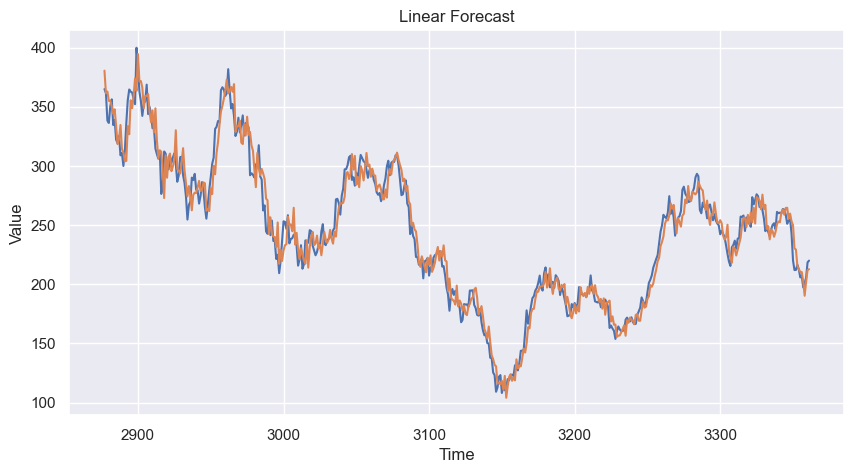

In [27]:
# Plot results
plt.title('Linear Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, lin_forecast)

#### Linear Model Result

In [30]:
linear_mea=keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()
linear_mea

9.456212

In [31]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Calculate RMSE
linear_rmse = np.sqrt(mean_squared_error(x_test, lin_forecast))
print(f"Root Mean Square Error (RMSE): {linear_rmse}")

Root Mean Square Error (RMSE): 12.252353530656013
